# 🤖 NOTEBOOK 2: ANÁLISE E MODELAGEM COM NLP
**Inferência de Gênero e Análise de Sentimento em Decisões Judiciais**

## 🔧 1. CONFIGURAÇÃO DO AMBIENTE

### 1.1 Instalação de Dependências (se necessário)

In [ ]:
!pip install transformers torch pandas scikit-learn scipy seaborn matplotlib

### 1.2 Importação de Bibliotecas Principais

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu

ImportError: cannot import name 'GenerationMixin' from 'transformers.generation' (/usr/local/lib/python3.12/dist-packages/transformers/generation/__init__.py)

## 📥 2. CARREGAMENTO DOS DADOS

### 2.1 Carregar Dataset com Textos Completos
**Descrição**: Carregamento do arquivo `decisoes_extraidas.csv` gerado no NOTEBOOK 1.

In [ ]:
df = pd.read_csv("decisoes_extraidas.csv", sep=';')

print(f"Shape do dataset: {df.shape}")
df.head()

Shape do dataset: (804, 3)


,arquivo,numero_processo,decisao_completa
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ..."
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE..."
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE..."
3,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE..."
4,00013144420188060151.pdf,0001314-44.2018.8.06.0151,"1ª Vara da Comarca de Quixadá Av. Jesus, Maria..."


## 🧠 3. EXTRAÇÃO DE ENTIDADES E INFERÊNCIA DE GÊNERO

### 3.1 Carregamento do Modelo NER Jurídico (LeNER-BR)
**Descrição**: Carregamento do modelo LeNER-BR, um BERT fine-tuned para reconhecimento de entidades nomeadas em textos jurídicos brasileiros (identifica nomes de pessoas, organizações, locais)

**Hugging Face 🤗**: https://huggingface.co/pierreguillou/ner-bert-base-cased-pt-lenerbr

In [ ]:
from transformers import pipeline

# Modelo NER especializado em textos jurídicos brasileiros
ner_pipeline = pipeline(
    "ner",
    model="pierreguillou/ner-bert-base-cased-pt-lenerbr",
    aggregation_strategy="simple"
)

Device set to use cuda:0


### 3.2 Função de Detecção de Título (Juiz/Juíza)
**Descrição**: Função que busca por padrões de "Juiz" ou "Juíza" nos últimos 2000 caracteres do texto (onde geralmente está a assinatura). Usa regex com normalização para capturar variações ortográficas.

In [ ]:
def detectar_titulo_juiz(texto):
    """
    Procura no texto ocorrências de 'Juiz' ou 'Juíza' e retorna:
      - 'Juiz'    se a última ocorrência for masculina
      - 'Juíza'   se a última ocorrência for feminina
      - 'N/A'     se não encontrar nada confiável
    """
    if not texto:
        return "N/A"

    # Olhando no fim do texto onde geralmente está a assinatura
    trecho_fim = texto[-2000:]

    # Padrão regex para capturar variações de Juiz/Juíza
    padrao = r"Ju[ií]z(a)?"

    # Busca pelo padrão ignorando capitalização
    judge_search = re.search(padrao, trecho_fim, flags=re.IGNORECASE)

    # Caso não encontrado -> N/A
    if not judge_search:
        return "N/A"

    # Recupera o termo encontrado
    judge = judge_search.group(0)

    # Decisão: se termina com 'a' → Juíza, senão → Juiz
    if "a" in judge.lower():
        return "Juíza"
    else:
        return "Juiz"

### 3.3 Função de Inferência de Gênero do Juiz
**Descrição**: Cconverte o título detectado em categoria de gênero.

In [ ]:
def inferir_genero_juiz_por_titulo(texto):
    """
    Usa o título para inferir o gênero do juiz(a).
    """
    titulo = detectar_titulo_juiz(texto)
    if titulo == "Juiz":
        return "Masculino"
    elif titulo == "Juíza":
        return "Feminino"
    else:
        return "N/A"

### 3.4 Aplicação das Funções ao Dataset

In [ ]:
df["titulo_juiz"] = df["decisao_completa"].apply(detectar_titulo_juiz)
df["genero_juiz"] = df["decisao_completa"].apply(inferir_genero_juiz_por_titulo)

df[["numero_processo", "titulo_juiz", "genero_juiz"]].sample(10, random_state=42)

,numero_processo,titulo_juiz,genero_juiz
192,0200226-69.2022.8.06.0143,Juiz,Masculino
717,0272599-05.2023.8.06.0001,Juiz,Masculino
168,0200082-88.2023.8.06.0037,Juíza,Feminino
522,0242527-98.2024.8.06.0001,Juíza,Feminino
536,0244939-36.2023.8.06.0001,Juíza,Feminino
790,0291464-13.2022.8.06.0001,Juiz,Masculino
698,0269896-04.2023.8.06.0001,Juíza,Feminino
328,0204029-56.2022.8.06.0112,Juiz,Masculino
218,0200436-05.2022.8.06.0052,Juíza,Feminino
662,0264768-66.2024.8.06.0001,Juíza,Feminino


### 3.5 Função de Extração de Nomes via NER
**Descrição**: Função para extração de nomes de pessoas usando NER, com múltiplos filtros:

* Exige pelo menos 2 palavras (nome + sobrenome)
* Remove termos institucionais/genéricos
* Exige mínimo de 3 caracteres

**Limitação**: Alguns documentos não têm nomes identificáveis nos primeiros 1000 caracteres (cabeçalhos, citações longas, ruído), resultando em "Não identificado".

In [ ]:
def extrair_pessoas_via_ner(texto):
    """
    Roda NER no texto e retorna lista de entidades do tipo PESSOA,
    filtrando tokens quebrados, exigindo pelo menos 2 palavras
    e ignorando termos institucionais/genéricos.
    """
    if not isinstance(texto, str) or texto.strip() == "":
        return []

    entities = ner_pipeline(texto)
    pessoas = []

    # Lista de termos que não queremos considerar como "Parte" (Pessoa Física)
    termos_proibidos = [
        "justiça pública", "justica publica",
        "ministério público", "ministerio publico",
        "município", "municipio",
        "estado do", "união", "uniao",
        "fazenda pública", "fazenda publica",
        "defensoria", "procuradoria",
        "banco", "seguradora", "imobiliária"
    ]

    for ent in entities:
        if ent.get("entity_group") != "PESSOA":
            continue

        nome = ent.get("word", "").strip()

        # Ignorar subwords esquisitos tipo '##no'
        if "##" in nome:
            continue

        # Remover caracteres estranhos
        nome_limpo = re.sub(r"[^A-Za-zÁÉÍÓÚÂÊÔÃÕÇáéíóúâêôãõç\s]", "", nome).strip()

        # Pelo menos 2 "palavras" (nome + sobrenome etc.)
        if len(nome_limpo.split()) < 2:
            continue

        # Pelo menos 1 letra "de verdade"
        if not re.search(r"[A-Za-zÁÉÍÓÚÂÊÔÃÕÇáéíóúâêôãõç]", nome_limpo):
            continue

        # Filtro de termos proibidos (institucionais)
        nome_lower = nome_limpo.lower()
        if any(term in nome_lower for term in termos_proibidos):
            continue

        pessoas.append({
            "nome": nome_limpo,
            "start": ent.get("start", None),
            "end": ent.get("end", None),
        })

    return pessoas

### 3.6 Função de Extração de Nomes das Partes (Estratégia Híbrida)
**Descrição**: Função principal de extração com estratégia híbrida em 3 camadas:

* Regex formal: Busca por "Requerente:", "Autor:", "Paciente:"
* Regex narrativa: Busca por "ajuizada por", "intentada por", "promovida por"
* NER fallback: Usa modelo de NLP quando padrões textuais falham

**Importante**: Analisa apenas os primeiros 1000 caracteres para otimizar performance.

In [ ]:
import re

TERMOS_PROIBIDOS = [
    "ministério público", "ministerio publico",
    "justiça pública", "justica publica",
    "estado do", "município", "municipio",
    "união", "uniao", "fazenda pública", "fazenda publica",
    "defensoria", "procuradoria", "secretaria", "prefeitura",
    "tribunal", "comarca", "vara", "juizado",
]

FRASES_RUIDO = [
    "para emendar", "emendar a inicial", "para emenda", "emenda da inicial",
    "a suportar", "suportar dores", "dores de", "forte intensidade",
    "possui histórico", "historico de", "encontra se", "encontra-se",
    "dependente para", "atividades da vida",
]

STOPWORDS_NOME = {
    "para","a","o","as","os","de","da","do","das","dos","e","em","no","na","nos","nas",
    "por","com","sem","ao","aos","à","às"
}

def eh_proibido(nome: str) -> bool:
    if not isinstance(nome, str):
        return True
    n = nome.strip().lower()
    if any(t in n for t in TERMOS_PROIBIDOS):
        return True
    if any(fr in n for fr in FRASES_RUIDO):
        return True
    return False

def limpar_nome(nome: str) -> str:
    if not isinstance(nome, str):
        return ""
    nome = nome.strip()

    # remove prefixos comuns que vazam
    nome = re.sub(r"(?i)^(e\s+)?(o\s+)?(a\s+)?autor(a)?\b[:\s-]*", "", nome).strip()
    nome = re.sub(r"(?i)^(o\s+)?(a\s+)?requerente\b[:\s-]*", "", nome).strip()
    nome = re.sub(r"(?i)^(o\s+)?(a\s+)?paciente\b[:\s-]*", "", nome).strip()

    # corta em delimitadores
    nome = re.split(r"[\n;,]", nome)[0].strip()

    # remove lixo não-letra
    nome = re.sub(r"[^A-Za-zÁÉÍÓÚÂÊÔÃÕÇáéíóúâêôãõç\s]", " ", nome)
    nome = re.sub(r"\s+", " ", nome).strip()
    return nome

def parece_nome_pessoa(nome: str) -> bool:
    if not isinstance(nome, str):
        return False
    nome = nome.strip()
    parts = [p for p in nome.split() if p]
    if len(parts) < 2:
        return False

    conteudo = [p for p in parts if p.lower() not in STOPWORDS_NOME]
    if len(conteudo) < 2:
        return False

    good = sum((w[:1].isupper() or w.isupper()) for w in conteudo)
    if good < 2:
        return False

    if any((len(w) >= 12 and not (w[:1].isupper() or w.isupper())) for w in conteudo):
        return False

    return True

def extrair_pessoas_via_ner(texto: str, limite_chars: int = 1000):
    """
    Retorna lista de nomes candidatos (strings) vindos do NER,
    já limpos e filtrados.
    """
    if not isinstance(texto, str) or not texto.strip():
        return []

    trecho = texto[:limite_chars]

    # IMPORTANTE: truncation/max_length evita RuntimeError do BERT
    ents = ner_pipeline(trecho)

    candidatos = []
    for ent in ents:
        if ent.get("entity_group") != "PESSOA":
            continue

        nome = limpar_nome(ent.get("word", ""))
        if not nome:
            continue

        if eh_proibido(nome):
            continue

        if not parece_nome_pessoa(nome):
            continue

        candidatos.append(nome)

    # remove duplicados preservando ordem
    vistos = set()
    out = []
    for n in candidatos:
        k = n.lower()
        if k not in vistos:
            vistos.add(k)
            out.append(n)
    return out

def extrair_nome_parte(texto: str, limite_chars: int = 2500) -> str:
    if not isinstance(texto, str) or texto.strip() == "":
        return "Não identificado"

    trecho = texto[:limite_chars]

    # 1) Rótulos formais
    padroes_formais = [
        r"(?im)^\s*Paciente\s*:\s*([^\n]{3,150})",
        r"(?im)^\s*Requerente\s*:\s*([^\n]{3,150})",
        r"(?im)^\s*Autor(?:a)?\s*:\s*([^\n]{3,150})",
        r"(?im)^\s*Parte\s+autora\s*:\s*([^\n]{3,150})",
        r"(?im)^\s*Demandante\s*:\s*([^\n]{3,150})",
        r"(?im)^\s*Impetrante\s*:\s*([^\n]{3,150})",
        r"(?im)^\s*Exequente\s*:\s*([^\n]{3,150})",
    ]

    for p in padroes_formais:
        m = re.search(p, trecho)
        if m:
            cand = limpar_nome(m.group(1))
            if cand and (not eh_proibido(cand)) and parece_nome_pessoa(cand):
                return cand

    # 2) Narrativos
    padroes_narrativos = [
        r"(?i)\bajuizad[ao]\s+por\s+([^,.;\n]{3,150})",
        r"(?i)\bintentad[ao]\s+por\s+([^,.;\n]{3,150})",
        r"(?i)\bpropost[ao]\s+por\s+([^,.;\n]{3,150})",
        r"(?i)\bpromovid[ao]\s+por\s+([^,.;\n]{3,150})",
    ]

    for p in padroes_narrativos:
        m = re.search(p, trecho)
        if m:
            cand = limpar_nome(m.group(1))
            if cand and (not eh_proibido(cand)) and parece_nome_pessoa(cand):
                return cand

    # 3) Fallback NER
    candidatos = extrair_pessoas_via_ner(trecho, limite_chars=1000)
    if candidatos:
        # escolha robusta: o nome mais longo costuma ser o mais completo
        return max(candidatos, key=lambda s: len(s))

    return "Não identificado"

### 3.7 Aplicando no dataframe

In [ ]:
df["nome_parte"] = df["decisao_completa"].apply(extrair_nome_parte)

### 3.8 Porcentagem de nomes das partes não identificadas

In [ ]:
nao_identificados = (df['nome_parte'] == "Não identificado").mean() * 100
n_nao_identificados = df['nome_parte'].eq("Não identificado").sum()

print(f"Porcentagem de nomes das partes não identificadas: {nao_identificados:.2f}%")
print(f"Quantidade: {n_nao_identificados}")

# Amostra
display(df[["numero_processo", "nome_parte"]].sample(5, random_state=42))

Porcentagem de nomes das partes não identificadas: 0.13%
Quantidade: 1


,numero_processo,nome_parte
588,0251984-57.2024.8.06.0001,Anderson Miguel Cordeiro da Silva
550,0246999-50.2021.8.06.0001,AMANDA DE PAULA VIEIRA
630,0258789-94.2022.8.06.0001,MIGUEL MARINONE DE SOUSA
115,0055880-40.2021.8.06.0117,Luiz Gonzaga Honório de Abreu
606,0254532-89.2023.8.06.0001,Marielly de Sousa Matias


### 3.9 Removendo registros não identificados do dataset


In [ ]:
# Removendo registros onde o nome da parte é 'Não identificado'
df = df[df['nome_parte'] != "Não identificado"]

print(f"Registros restantes: {df.shape[0]}")
df.tail(15)

Registros restantes: 776


,arquivo,numero_processo,decisao_completa,titulo_juiz,genero_juiz,nome_parte,genero_parte
787,02886306620248060001.pdf,0288630-66.2024.8.06.0001,Plantão Judiciário Cível Rua Desembargador Flo...,Juiz,Masculino,Floriano Benevides Magalhaes,Masculino
788,02892655220218060001.pdf,0289265-52.2021.8.06.0001,28ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Juíza,Feminino,no Benevides Magalhaes,Masculino
789,02910363120228060001.pdf,0291036-31.2022.8.06.0001,26ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Juiz,Masculino,LUIS BARROS MONTENEGRO NETO em face da HAPVIDA...,Masculino
790,02914641320228060001.pdf,0291464-13.2022.8.06.0001,25ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Juiz,Masculino,Francisco Ferreira dos Santos,Masculino
791,02915343020228060001.pdf,0291534-30.2022.8.06.0001,37ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Juiz,Masculino,Floriano Benevides Magalhaes,Feminino
792,02921466520228060001.pdf,0292146-65.2022.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Juíza,Feminino,Maria Clara Guimarães de Figueiredo,Feminino
793,02940468320228060001.pdf,0294046-83.2022.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Juíza,Feminino,Francisco Claudio de Andrade Lima Filho,Masculino
794,02964882220228060001.pdf,0296488-22.2022.8.06.0001,10ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Juíza,Feminino,PEDRO EVANDRO BANDEIRA LESSA e outro em face d...,Masculino
795,02965661620228060001.pdf,0296566-16.2022.8.06.0001,14ª Vara de Família (SEJUD 1º Grau) Rua Desemb...,Juiz,Masculino,Adriano José Nascimento de Oliveira em face de...,Masculino
796,02969914320228060001.pdf,0296991-43.2022.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Juíza,Feminino,Floriano Benevides Magalhaes,Masculino


### 3.10 Carregamento do Modelo Zero-Shot Classification (Bart-Large-MNLI)
**Descrição**: Carregamento do modelo facebook/bart-large-mnli, um modelo BART de grande porte treinado no dataset MultiNLI (MNLI), utilizado para classificação de textos em zero-shot para tarefas de classificação, análise de conteúdo e rotulagem. Em nosso caso, a análise do gênero baseado no nome da parte

**Hugging Face** 🤗: https://huggingface.co/facebook/bart-large-mnli



In [ ]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")


Device set to use cuda:0


### 3.11 Função de Inferência de Gênero da Parte (via Nome com Zero-Shot)

In [ ]:
def identificar_genero(nome):
    """
    Usa zero-shot classification para inferir o gênero a partir do PRIMEIRO nome.
    Retorna 'Masculino' ou 'Feminino'.
    """
    if not isinstance(nome, str) or nome.strip() == "" or nome == "Não identificado":
        return "N/A"

    # Pegar apenas o primeiro nome para evitar ruído dos sobrenomes
    primeiro_nome = nome.strip().split()[0]

    labels = ["Masculino", "Feminino"]

    resultado = classifier(
        primeiro_nome,
        candidate_labels=labels,
        hypothesis_template="Este nome pertence ao gênero {}."
    )

    # O pipeline retorna ordenado por score decrescente, então o índice 0 é o vencedor
    return resultado["labels"][0]

### 3.12 Aplicando a função de indentificação de gênero para a parte

In [ ]:
df["genero_parte"] = df["nome_parte"].apply(identificar_genero)

df[["numero_processo", "nome_parte", "genero_parte", "titulo_juiz", "genero_juiz"]].head()

,numero_processo,nome_parte,genero_parte,titulo_juiz,genero_juiz
0,0000303-16.2017.8.06.0215,José Arteiro de Araújo,Masculino,Juiz,Masculino
1,0000498-37.2018.8.06.0127,Maria Jose Silva de Araujo,Feminino,Juíza,Feminino
2,0000618-80.2018.8.06.0127,Luiz Mateus Santos da Costa,Masculino,Juíza,Feminino
3,0000965-79.2019.8.06.0127,Francisco Roberto Rodrigues da Silva,Masculino,Juíza,Feminino
4,0001314-44.2018.8.06.0151,Y FERREIRA DE OLIVEIRA,Masculino,Juiz,Masculino


### 3.13 Verificando existência de valores nulos

In [ ]:
# Contar quantidade de valores nulos (NaN) nas colunas de gênero
nulos_genero = df[['genero_juiz', 'genero_parte']].isna().sum()
print(nulos_genero)

display(df.head(4))

genero_juiz     0
genero_parte    0
dtype: int64


,arquivo,numero_processo,decisao_completa,titulo_juiz,genero_juiz,nome_parte,genero_parte
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Juiz,Masculino,José Arteiro de Araújo,Masculino
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Juíza,Feminino,Maria Jose Silva de Araujo,Feminino
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Juíza,Feminino,Luiz Mateus Santos da Costa,Masculino
3,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Juíza,Feminino,Francisco Roberto Rodrigues da Silva,Masculino


### 3.14 Removendo colunas parciais de nome

In [ ]:
df = df.drop(columns=["nome_parte", "titulo_juiz"])

In [ ]:
display(df)

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino
3,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino
4,00013144420188060151.pdf,0001314-44.2018.8.06.0151,"1ª Vara da Comarca de Quixadá Av. Jesus, Maria...",Masculino,Masculino
...,...,...,...,...,...
797,08000022220228060163.pdf,0800002-22.2022.8.06.0163,2ª Vara da Comarca de São Benedito Av. Tabajar...,Feminino,Feminino
799,08000076520238060177.pdf,0800007-65.2023.8.06.0177,"Rua Carlos Antônio Sales, nº 401, Centro - CEP...",Masculino,Masculino
801,08000093520238060177.pdf,0800009-35.2023.8.06.0177,"Rua Carlos Antônio Sales, nº 401, Centro - CEP...",Masculino,Masculino
802,08000118820228060096.pdf,0800011-88.2022.8.06.0096,"CEL. GUILHERMINO, S/N, PRAÇA DE CRISTO - CEP 6...",Feminino,Masculino


### 3.15 Salvando resultados parciais

In [ ]:
df.to_csv("decisoes_com_genero.csv", index=False, sep=";")

## 🎯 4. CLASSIFICAR SENTENÇAS EM PROCEDENTES E IMPROCEDENTES


### 4.1 Função de classificação
**Descrição**: Aqui vamos usar regras de palavras-chave. Ajuste os termos conforme você observar nos textos do seu tribunal.

**Regras**:

1. Se contém a palavra "IMPROCEDENTE" ou sinônimo: `Improcedente`

1. Se contém "PROCEDENTE" ou sinônimo: `Procedente`

1. Caso contrário: `Não identificado`

In [ ]:
def classificar_sentenca(texto):
    t = texto.upper()

    if "JULGO IMPROCEDENTE" in t or "JULGAM IMPROCEDENTE" in t:
        return "Improcedente"

    if "JULGO PROCEDENTE" in t or "JULGAM PROCEDENTE" in t:
        return "Procedente"

    if "IMPROCEDENTE" in t or "INDEFERIDO" or "INDEFIRO" in t:
        return "Improcedente"
    if "PROCEDENTE" in t or "DEFERIDO" in t or "DEFIRO" in t:
        return "Procedente"

    return "Não identificado"


### 4.2 Aplicando classificação de sentença no dataframe

In [ ]:
df["resultado_sentenca"] = df["decisao_completa"].apply(classificar_sentenca)

df["resultado_sentenca"].value_counts(dropna=False)

,count
resultado_sentenca,
Procedente,549
Improcedente,227


### 4.3 Verificando resultados antes de salvar

In [ ]:
print(df.columns)
print(df.shape)
df.head(5)

Index(['arquivo', 'numero_processo', 'decisao_completa', 'genero_juiz',
       'genero_parte', 'resultado_sentenca'],
      dtype='object')
(776, 6)


,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino,Procedente
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente
3,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente
4,00013144420188060151.pdf,0001314-44.2018.8.06.0151,"1ª Vara da Comarca de Quixadá Av. Jesus, Maria...",Masculino,Masculino,Improcedente


### 4.4 Salvando resultados

In [ ]:
# Salvando em csv

df.to_csv("decisoes_classificadas_com_genero.csv", index=False, sep=";")

## 📚 5. PRÉ-PROCESSAMENTO DO TEXTO

- https://garyeckstein.com/clean-text-for-data-analysis/

### 5.1 Removendo espaços em branco


In [ ]:
# Remove whitespaces
def remove_whitespaces(decisao_completa):
    return  " ".join(decisao_completa.split())

df['decisao_completa']=df['decisao_completa'].apply(remove_whitespaces)
df.head(5)

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino,Procedente
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente
3,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente
4,00013144420188060151.pdf,0001314-44.2018.8.06.0151,"1ª Vara da Comarca de Quixadá Av. Jesus, Maria...",Masculino,Masculino,Improcedente


### 5.2 Lematização
**Descrição**: Mapeia palavras para suas formas base de dicionário, conhecida como **lema**.

Ex: lematização de "sou" retorna "ser"

Por que é importante: reduzir dimensionalidade dos dados sem perder contexto semântico, melhorando classificação em NLP

A lematização foi realizada antes da remoção de stopwords e pontuação, a fim de preservar o contexto morfossintático das sentenças, garantindo maior precisão linguística na normalização dos termos jurídicos.


### 5.3 Instalando e importando bibliotecas

In [ ]:
!pip -q install spacy
!python -m spacy download pt_core_news_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 31.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

nlp = spacy.load("pt_core_news_sm", disable=["ner", "parser"])
# Mantém o tagger/lemmatizer e desliga o resto para ficar mais rápido.

### 5.4 Função de lemetização

In [ ]:
def lemmatize_spacy_from_token_lists(lista_de_listas_tokens, batch_size=64, n_process=1):
    """
    Entrada: lista_de_listas_tokens -> [ ["token1","token2",...], ["token1",...], ... ]
    Saída: lista de listas de lemas (mesmo shape)
    """
    # transforma cada doc em string (spacy precisa de texto)
    textos = (" ".join(tokens) for tokens in lista_de_listas_tokens)

    saida = []
    for doc in nlp.pipe(textos, batch_size=batch_size, n_process=n_process):
        saida.append([t.lemma_ for t in doc])
    return saida

### 5.5 Aplicando no dataset

In [ ]:
df["lemmas"] = [
    [t.lemma_ for t in doc]
    for doc in nlp.pipe(df["decisao_completa"].tolist(), batch_size=100, n_process=-1)
]
df.head(3)

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,lemmas
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino,Procedente,"[Av, Paulo, Bastos, ,, 802, ,, Centro, -, CEP,..."
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente,"[PRAÇA, LUIZ, ALVES, de, MESQUITA, ,, S, /, N,..."
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,"[PRAÇA, LUIZ, ALVES, de, MESQUITA, ,, S, /, N,..."


### 5.6 Baixando nltk (Natural Language Toolkit) para realizar o pré-processamento e preparação do texto

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Load NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('portuguese'))
en_stopwords = stopwords.words('portuguese')

# Criando um dataframe para salvar em csv as stopwords
df_stopwords = pd.DataFrame(en_stopwords, columns=['stopwords'])
df_stopwords.to_csv('custom_stopwords.csv', index=False)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### 5.7 Carregando stopwords

In [ ]:
# Load custom stopwords
with open(r'custom_stopwords.csv', 'r') as f:
    custom_stopwords = f.read().strip().split(",")

custom_stopwords

### 5.8 Removendo stopwords

In [ ]:
# Remove the stopwords

def remove_stopwords(lemmas):
    result = []
    for token in lemmas:
        if token not in en_stopwords and token not in custom_stopwords:
            result.append(token)

    return result

df['lemmas'] = df['lemmas'].apply(remove_stopwords)
df.head(3)

### 5.9. Removendo pontuação

In [ ]:
# Remove punctuation
from nltk.tokenize import RegexpTokenizer

def remove_punct(lemmas):

    tokenizer = RegexpTokenizer(r"\w+")
    lst=tokenizer.tokenize(' '.join(lemmas))
    return lst

df['lemmas'] = df['lemmas'].apply(remove_punct)
df.head(3)

### 5.10 Transformando em string novamente

In [ ]:
# Convert list to string
df['decisao_processada'] = [' '.join(map(str, l)) for l in df['lemmas']]
df.head(3)

### 5.11 Remove palavras com 2 caracteres ou menos

In [ ]:
#Remove words 2 characters in length and less
df['decisao_processada'] = df.decisao_processada.str.replace(r'\b(\w{1,2})\b', '', regex=True)

df.head(3)

### 5.12 Remove espaços em branco e urls

In [ ]:
import re
# Remove whitespaces and urls
def remove_whitespaces(decisao_processada):
    return  " ".join(decisao_processada.split())

def remove_url(decisao_processada):
    return re.sub(r'http\S+|www.\S+', '', decisao_processada)


df['decisao_processada']=df['decisao_processada'].apply(remove_whitespaces).apply(remove_url)
df.head(3)

### 5.13 Limpando coluna de lemmas

In [ ]:
# removendo coluna lemmas

df = df.drop(columns=['lemmas'])
df.head(3)

### 5.14 Salvando resultados

In [ ]:
df.to_csv("decisoes_processadas_genero.csv", index=False, sep=";")

## 🤖 6. ANÁLISE DE SENTIMENTO COM LLM
**Observação**: Pule a execução dessa sessão, apenas veja os resultados gerados.

### 6.1 Carregando o csv com decisões pré-processadas e gêneros inferidos

In [ ]:
df = pd.read_csv("decisoes_processadas_genero.csv", sep=";")

### 6.2 Instalando OpenRouter
**Descrição**: O OpenRouter funciona como um hall de modelos, facilitando o uso de diferentes LLMs.

In [ ]:
%pip install llama-index-llms-openrouter
!pip install llama-index

### 6.3 Importando bibliotecas

In [ ]:
from llama_index.llms.openrouter import OpenRouter
from llama_index.core.llms import ChatMessage

### 6.4 Configurando API Key do OpenRouter


In [ ]:
import os
from google.colab import userdata

os.environ['OPENROUTER_API_KEY'] = userdata.get("Open-Router_API-KEY")

### 6.5 Configuração dos modelos
**Descrição**: Foram avaliados múltiplos modelos disponíveis no OpenRouter, permitindo comparação de estabilidade e coerência:

* mistralai/mixtral-8x7b-instruct
* openai/gpt-oss-120b
* openai/gpt-4o-mini
* meta-llama/llama-3.3-70b-instruct
* deepseek/deepseek-v3.2
* x-ai/grok-4.1-fast

**Referência**: https://openrouter.ai/docs

In [ ]:
llm_mistral = OpenRouter(model="mistralai/mixtral-8x7b-instruct")
llm_gpt = OpenRouter(model="openai/gpt-oss-120b")
llm_gpt_mini = OpenRouter(model="openai/gpt-4o-mini")
llm_llama = OpenRouter(model="meta-llama/llama-3.3-70b-instruct")
llm_deepseek = OpenRouter(model="deepseek/deepseek-v3.2")
llm_grok = OpenRouter(model="x-ai/grok-4.1-fast")

### 6.6 Função de prompt
**Descrição**: O prompt foi cuidadosamente projetado para:

* Restringir o modelo ao texto pré-processado;
* Fornecer contexto estruturado mínimo (resultado da sentença, gênero do juiz e da parte);
* Evitar explicações, justificativas ou vieses externos.

A classificação é feita em **três categorias** exclusivas:

* **EMPÁTICA** – Linguagem humanizada e snsível ao contexto da parte;
* **TÉCNICA** – Linguagem neutra, objetiva e predominantemente jurídica;
* **RIGOROSA** – Linguagem dura, formal ou censória, com

In [ ]:
import re
import time
from llama_index.core.llms import ChatMessage

def montar_prompt(resultado_sentenca, genero_juiz, genero_parte, decisao_processada) -> str:
    return f"""
Você é um especialista em análise de linguagem jurídica e argumentação judicial.

Sua tarefa é classificar o **TOM DA DECISÃO JUDICIAL** com base **EXCLUSIVAMENTE**:
- no texto da decisão (pré-processado)
- no contexto estruturado fornecido

# DIRETRIZES
- NÃO avalie correção jurídica, justiça da decisão ou resultado do processo.
- NÃO use conhecimentos externos.
- NÃO explique sua resposta.

────────────────────────────────
# CONTEXTO ESTRUTURADO
────────────────────────────────
Resultado da sentença: {resultado_sentenca}
Gênero do(a) juiz(a): {genero_juiz}
Gênero da parte: {genero_parte}

────────────────────────────────
# TEXTO DA DECISÃO (pré-processado)
────────────────────────────────
\"\"\"{decisao_processada}\"\"\"

────────────────────────────────
# CRITÉRIOS DE CLASSIFICAÇÃO
────────────────────────────────

Classifique o TOM predominante do texto em **APENAS UMA** das categorias abaixo:

• **EMPATICA**
  - Linguagem humanizada ou acolhedora
  - Demonstra preocupação com dignidade, sofrimento, vulnerabilidade ou situação pessoal da parte
  - Uso de expressões que reconhecem contexto social, humano ou existencial
  - Mesmo quando técnica, apresenta sensibilidade explícita

• **TECNICA**
  - Linguagem neutra e impessoal
  - Fundamentação jurídica objetiva
  - Predomínio de dispositivos legais, precedentes, conceitos jurídicos
  - Ausência de juízo emocional positivo ou negativo

• **RIGOROSA**
  - Linguagem dura, fria ou excessivamente formal
  - Tom repreensivo, censório ou de pouca concessão
  - Ênfase em limites legais sem contextualização humana
  - Eventual censura moral, reprovação ou desconsideração da situação da parte

────────────────────────────────
# FORMATO OBRIGATÓRIO DE SAÍDA
────────────────────────────────

Retorne **EXATAMENTE UMA PALAVRA**, em letras maiúsculas, sem pontuação, sem explicações adicionais:

EMPATICA
TECNICA
RIGOROSA
"""

def extrair_sentimento(texto):
    t = texto.strip().upper()
    # pega a primeira ocorrência de uma classe válida
    m = re.search(r"\b(EMPATICA|TECNICA|RIGOROSA)\b", t)
    return m.group(1)

def classificar_tom(row, llm, max_retries=3) -> str:
    prompt = montar_prompt(
        row["resultado_sentenca"],
        row["genero_juiz"],
        row["genero_parte"],
        row["decisao_processada"],
    )

    msg = ChatMessage(role="user", content=prompt)

    for _ in range(max_retries):
        try:
            resp = llm.chat([msg])
            return extrair_sentimento(str(resp))

        except Exception:
            time.sleep(1)

    return "ERRO"


### 6.7 Aplicação no dataframe a análise de cada um dos modelos

In [ ]:
# @title Mistral
df["sentimento_llm_mistral"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_mistral), axis = 1)

In [ ]:
# @title GPT
df["sentimento_llm-gpt"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_gpt), axis = 1)

In [ ]:
# @title GPT Mini
df["sentimento_llm-gpt-mini"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_gpt_mini), axis = 1)

In [ ]:
# @title Llama
df["sentimento_llm-llama"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_llama), axis = 1)

In [ ]:
# @title DeepSeek
df["sentimento_llm-deep-seek"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_llama), axis = 1)

In [ ]:
# @title Grok
df["sentimento_llm-grok"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_grok), axis = 1)

### 6.8 Geração dos resultados encontrados

In [ ]:
# @title Lendo o csv com as decisões já processadas
import pandas as pd
df = pd.read_csv("decisoes_classificadas_cs_llm.csv", sep=";")

In [91]:
display(df['resultado_sentenca'].value_counts())

display(df['sentimento_llm_mistral'].value_counts())
display(df['sentimento_llm-gpt'].value_counts())
display(df['sentimento_llm-gpt-mini'].value_counts())
display(df['sentimento_llm-llama'].value_counts())
display(df['sentimento_llm-deep-seek'].value_counts())
display(df['sentimento_llm-grok'].value_counts())

display(df.head(4))

,count
resultado_sentenca,
Procedente,539
Improcedente,213


,count
sentimento_llm_mistral,
EMPATICA,663
TECNICA,89


,count
sentimento_llm-gpt,
TECNICA,722
EMPATICA,22
ERRO,7
RIGOROSA,1


,count
sentimento_llm-gpt-mini,
EMPATICA,382
TECNICA,224
RIGOROSA,146


,count
sentimento_llm-llama,
TECNICA,708
EMPATICA,44


,count
sentimento_llm-deep-seek,
TECNICA,711
EMPATICA,41


,count
sentimento_llm-grok,
EMPATICA,525
TECNICA,222
RIGOROSA,5


,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,decisao_processada,sentimento_llm_mistral,sentimento_llm-gpt,sentimento_llm-gpt-mini,sentimento_llm-llama,sentimento_llm-deep-seek,sentimento_llm-grok,trecho_decisao_4096,trecho_decisao_512,analise_bert_label,analise_bert_1a5,analise_bert,grupo_jp
0,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,", com fulcro no art. 487, I do CPC julgo PROCE...",", com fulcro no art. 487, I do CPC julgo PROCE...",1 star,1,RIGOROSA,Juiz Feminino / Parte Feminino
1,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...,EMPATICA,ERRO,EMPATICA,EMPATICA,EMPATICA,EMPATICA,", com fulcro no art. 487, I do CPC julgo PROCE...",", com fulcro no art. 487, I do CPC julgo PROCE...",1 star,1,RIGOROSA,Juiz Feminino / Parte Masculino
2,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,", com fulcro no art. 487, I do CPC julgo PROCE...",", com fulcro no art. 487, I do CPC julgo PROCE...",1 star,1,RIGOROSA,Juiz Feminino / Parte Masculino
3,00013144420188060151.pdf,0001314-44.2018.8.06.0151,"1ª Vara da Comarca de Quixadá Av. Jesus, Maria...",Masculino,Masculino,Improcedente,Vara Comarca Quixadá Jesus Maria José Jardim M...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA,", confirmo os efeitos da tutela de urgência pa...",", confirmo os efeitos da tutela de urgência pa...",1 star,1,RIGOROSA,Juiz Masculino / Parte Masculino


### 6.9 Salvando resultados das decisoes classificadas

In [ ]:
# Salvando em csv:

df.to_csv("decisoes_classificadas_cs_llm.csv", index=False, sep=";")

## 🔍 7. EXTRAÇÃO DO TRECHO DECISÓRIO VIA REGEX

### 7.1 Definição de Padrões de Decisão e Âncoras
**Descrição**: Padrões regex para identificar termos decisórios e âncoras textuais que marcam o início da parte dispositiva da sentença.

In [ ]:
import re

# 1) Decisões
padroes_decisao = re.compile(
    r"(?is)\b("
    r"julgo|"
    r"defiro|indefiro|"
    r"procedente|improcedente|"
    r"parcialmente\s+procedente|"
    r"extingo|"
    r"condeno|"
    r"homologo|"
    r"nego\s+provimento|dou\s+provimento|"
    r"rejeito|acolho"
    r")\b"
)

# 2) Âncoras para decisões
padroes_ancora = re.compile(
    r"(?im)\b("
    r"(?:do\s+)?dispositivo\b(?!s)|"
    r"ante\s+o\s+exposto|"
    r"isso\s+posto|isto\s+posto|"
    r"pelo\s+exposto|por\s+todo\s+o\s+exposto|"
    r"diante\s+disso|diante\s+do\s+exposto"
    r")\b"
)

### 7.2 Função de Extração do Trecho Decisório
**Descrição**: Extrai o trecho relevante da decisão judicial (dispositivo) usando âncoras textuais e padrões de decisão.

**Estratégia**:

1. Analisa apenas o final do documento (últimos 20.000 caracteres)
2. Prioridade: última âncora encontrada
3. Fallback: última semente de decisão
3. Fallback final: final do texto


**Justificativa**: O sentimento mais relevante está na parte decisória (dispositivo), não no relatório ou fundamentação.

In [ ]:
def extrair_trecho_decisao_simples(texto: str, n_chars: int = 4096, janela_back: int = 20000, lado: str = "inicio") -> str:
    """
    Retorna APENAS o trecho decisório.
    lado:
      - "inicio": pega os PRIMEIROS n_chars após âncora/decisão (ideal p/ 512)
      - "fim":    pega os ÚLTIMOS n_chars do trecho após âncora/decisão (ok p/ 4096)
    """
    if not isinstance(texto, str) or not texto.strip():
        return ""

    tail = texto[-janela_back:] if len(texto) > janela_back else texto
    offset = len(texto) - len(tail)

    start = None

    # 1) tenta âncora
    anc = list(padroes_ancora.finditer(tail))
    if anc:
        m = anc[-1]
        start = offset + m.end()
    else:
        # 2) tenta decisão
        dec = list(padroes_decisao.finditer(tail))
        if dec:
            m = dec[-1]
            start = offset + m.start()

    # 3) fallback
    if start is None:
        trecho = texto[-janela_back:]
    else:
        trecho = texto[start:]

    if lado == "fim":
        return trecho[-n_chars:].strip()
    else:  # "inicio"
        return trecho[:n_chars].strip()

### 7.3 Aplicação da Extração para Diferentes Tamanhos
**Descrição**: Extração de trechos decisórios em dois tamanhos diferentes:

* **512 caracteres**: Para modelos BERT padrão
* **4096 caracteres**: Para modelos Longformer

In [ ]:
df["trecho_decisao_4096"] = df["decisao_completa"].astype(str).apply(
    lambda t: extrair_trecho_decisao_simples(t, n_chars=4096)
)

df["trecho_decisao_512"] = df["decisao_completa"].astype(str).apply(
    lambda t: extrair_trecho_decisao_simples(t, n_chars=512)
)

### 7.4 Verificação da Qualidade das Extrações
**Descrição**: Validação de que os trechos extraídos contêm palavras decisórias.

In [ ]:
df["trecho_tem_palavra_decisao_4096"] = df["trecho_decisao_4096"].apply(
    lambda s: bool(padroes_decisao.search(s)) if isinstance(s, str) else False
)

df["trecho_tem_palavra_decisao_512"] = df["trecho_decisao_512"].apply(
    lambda s: bool(padroes_decisao.search(s)) if isinstance(s, str) else False
)

# Porcentagens de qualidade
print(f"4096 - contém decisão: {(df['trecho_tem_palavra_decisao_4096'].mean() * 100):.2f} %")
print(f"512  - contém decisão: {(df['trecho_tem_palavra_decisao_512'].mean() * 100):.2f} %")
display(df.sample(5))

4096 - contém decisão: 94.68 %
512  - contém decisão: 91.76 %


,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,decisao_processada,sentimento_llm_mistral,sentimento_llm-gpt,sentimento_llm-gpt-mini,sentimento_llm-llama,sentimento_llm-deep-seek,sentimento_llm-grok,trecho_decisao_4096,trecho_decisao_512,trecho_tem_palavra_decisao_4096,trecho_tem_palavra_decisao_512
537,02491120620238060001.pdf,0249112-06.2023.8.06.0001,17ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Masculino,Feminino,Procedente,17ª Vara Cível SEJUD Grau Rua Desembargador Fl...,EMPATICA,TECNICA,TECNICA,TECNICA,TECNICA,EMPATICA,"Ante ao exposto, JULGO PROCEDENTE a presente a...","Ante ao exposto, JULGO PROCEDENTE a presente a...",True,True
530,02485786220238060001.pdf,0248578-62.2023.8.06.0001,31ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Feminino,Masculino,Procedente,31ª Vara Cível SEJUD Grau Rua Desembargador Fl...,TECNICA,TECNICA,EMPATICA,TECNICA,TECNICA,TECNICA,condeno a promovida ao pagamento das custas e ...,condeno a promovida ao pagamento das custas e ...,True,True
83,00522164220218060071.pdf,0052216-42.2021.8.06.0071,2ª Vara Cível da Comarca de Crato Rua Álvaro P...,Masculino,Masculino,Procedente,Vara Cível Comarca Crato Rua Álvaro Peixoto Sã...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA,condeno o Município em honorários em favor da ...,condeno o Município em honorários em favor da ...,True,True
94,00534199520218060117.pdf,0053419-95.2021.8.06.0117,1ª Vara Cível da Comarca de Maracanaú Rua Luiz...,Feminino,Feminino,Improcedente,Vara Cível Comarca Maracanaú Rua Luiz Gonzaga ...,EMPATICA,TECNICA,RIGOROSA,TECNICA,TECNICA,EMPATICA,condeno a parte ré ao pagamento dos honorários...,condeno a parte ré ao pagamento dos honorários...,True,True
266,02017280220238060113.pdf,0201728-02.2023.8.06.0113,"Rua José Facundo Leite, S/N, Centro - CEP 6358...",Masculino,Masculino,Improcedente,Rua José Facundo Leite Centro CEP 63580 000 Fo...,TECNICA,TECNICA,TECNICA,TECNICA,TECNICA,TECNICA,", julgo extinto o presente processo, sem análi...",", julgo extinto o presente processo, sem análi...",True,True


### 7.5 Removendo colunas intermediárias

In [ ]:
df = df.drop(columns=["trecho_tem_palavra_decisao_4096", "trecho_tem_palavra_decisao_512"])

### 7.6 Verificando resultados

In [ ]:
display(df.sample(5))

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,decisao_processada,sentimento_llm_mistral,sentimento_llm-gpt,sentimento_llm-gpt-mini,sentimento_llm-llama,sentimento_llm-deep-seek,sentimento_llm-grok,trecho_decisao_4096,trecho_decisao_512
457,02363055120238060001.pdf,0236305-51.2023.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Feminino,Feminino,Procedente,Vara Infância Juventude Rua Desembargador Flor...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA,", considerando tudo mais que dos autos consta,...",", considerando tudo mais que dos autos consta,..."
54,00509156820208060112.pdf,0050915-68.2020.8.06.0112,"Norte Av. Maria Letícia Leite Pereira, S/N, An...",Masculino,Feminino,Procedente,Norte Maria Letícia Leite Pereira Anexo Unileã...,EMPATICA,TECNICA,TECNICA,TECNICA,TECNICA,TECNICA,", considerando tudo o que nos autos consta, co...",", considerando tudo o que nos autos consta, co..."
628,02647589020228060001.pdf,0264758-90.2022.8.06.0001,3ª Vara Cível (SEJUD 1º Grau) Rua Desembargado...,Masculino,Feminino,Procedente,Vara Cível SEJUD Grau Rua Desembargador Floria...,EMPATICA,TECNICA,RIGOROSA,TECNICA,TECNICA,EMPATICA,", (I) ratifico a decisão liminar proferida às ...",", (I) ratifico a decisão liminar proferida às ..."
734,02841187420238060001.pdf,0284118-74.2023.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Feminino,Masculino,Procedente,Vara Infância Juventude Rua Desembargador Flor...,EMPATICA,TECNICA,TECNICA,TECNICA,TECNICA,EMPATICA,", considerando tudo mais que dos autos consta,...",", considerando tudo mais que dos autos consta,..."
488,02424144720248060001.pdf,0242414-47.2024.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Masculino,Feminino,Improcedente,Vara Infância Juventude Rua Desembargador Flor...,TECNICA,TECNICA,RIGOROSA,TECNICA,TECNICA,TECNICA,", considerando tudo mais que dos autos consta,...",", considerando tudo mais que dos autos consta,..."


### 7.7 Salvando resultados

In [ ]:
df.to_csv("decisoes_classificadas_cs_llm_regex.csv", index=False, sep=";")

## 💬 8. ANÁLISE DE SENTIMENTO COM BERT e RoBERTa

### 8.1 Carregamento dos Modelos BERT e RoBERTa
**Descrição**: Modelo BERT fine-tuned para análise de sentimento (512 tokens) em avaliações de produtos em 6 idiomas (incluindo português). Prediz sentimento em escala de 1 a 5 estrelas. Modelo RoBERTa que contém maior janela de tokens para análise (4096 tokens).

**Hugging Face** 🤗:
* BERT: https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
* RoBERTa: https://huggingface.co/markussagen/xlm-roberta-longformer-base-4096

In [1]:
!pip uninstall -y transformers tokenizers huggingface-hub safetensors
!pip install -U --no-cache-dir "transformers==4.56.2" "tokenizers==0.22.1" "huggingface-hub==0.35.3" "safetensors>=0.4.3"

from transformers import pipeline

bert_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    truncation=True,
    max_length=512
  )

Found existing installation: transformers 4.56.2
Uninstalling transformers-4.56.2:
  Successfully uninstalled transformers-4.56.2
Found existing installation: tokenizers 0.22.1
Uninstalling tokenizers-0.22.1:
  Successfully uninstalled tokenizers-0.22.1
Found existing installation: huggingface-hub 0.35.3
Uninstalling huggingface-hub-0.35.3:
  Successfully uninstalled huggingface-hub-0.35.3
Found existing installation: safetensors 0.7.0
Uninstalling safetensors-0.7.0:
  Successfully uninstalled safetensors-0.7.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 336.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 401.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 397.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.2/507.2 kB 407.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [2]:
roberta_pipeline = pipeline(
    "sentiment-analysis",
    model="markussagen/xlm-roberta-longformer-base-4096",
    truncation=True,
    max_length=4096
  )

config.json:   0%|          | 0.00/773 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at markussagen/xlm-roberta-longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


### 8.2 Testando análise de sentimentos antes de prosseguir para o dataset completo

In [3]:
textos_teste = [
    # Texto 1 – Empático / Procedente
    "Diante da vulnerabilidade da parte autora e da comprovada necessidade do medicamento, "
    " procedente o pedido, assegurando o direito fundamental à saúde.",

    # Texto 2 – Rigoroso / Improcedente
    "Não restou comprovado o direito alegado. Ausente prova mínima dos fatos constitutivos, "
    "julgo improcedente o pedido, nos termos da legislação vigente."
]

# BERT (512)
saida_bert = bert_pipeline(textos_teste)

# RoBERTa Longformer (4096)
saida_roberta = roberta_pipeline(textos_teste)

print("=== BERT ===")
for t, s in zip(textos_teste, saida_bert):
    print("\nTexto:", t)
    print("Saída:", s)

print("\n=== RoBERTa ===")
for t, s in zip(textos_teste, saida_roberta):
    print("\nTexto:", t)
    print("Saída:", s)


=== BERT ===

Texto: Diante da vulnerabilidade da parte autora e da comprovada necessidade do medicamento,  procedente o pedido, assegurando o direito fundamental à saúde.
Saída: {'label': '5 stars', 'score': 0.2671985328197479}

Texto: Não restou comprovado o direito alegado. Ausente prova mínima dos fatos constitutivos, julgo improcedente o pedido, nos termos da legislação vigente.
Saída: {'label': '1 star', 'score': 0.5797569155693054}

=== RoBERTa ===

Texto: Diante da vulnerabilidade da parte autora e da comprovada necessidade do medicamento,  procedente o pedido, assegurando o direito fundamental à saúde.
Saída: {'label': 'LABEL_0', 'score': 0.5381667613983154}

Texto: Não restou comprovado o direito alegado. Ausente prova mínima dos fatos constitutivos, julgo improcedente o pedido, nos termos da legislação vigente.
Saída: {'label': 'LABEL_0', 'score': 0.5421473979949951}


### 8.3 Conclusão sobre testes realizados acima
**Descrição**: Os testes indicaram que, embora utilize rótulos genéricos de sentimento, o modelo BERT apresentou respostas coerentes com a polaridade dos textos analisados. Já o RoBERTa não distinguiu adequadamente textos semanticamente distintos, por conta disso, continuaremos somente com as análises do modelo BERT.

### 8.4 Funções Auxiliares para Processamento em Batch
**Descrição**: Função para processar múltiplos textos em batches, otimizando performance.

In [4]:
def _rodar_pipeline_em_batch(textos, pipe, batch_size=8):
    """
    Roda pipeline em batches e retorna lista de dicts [{'label':..., 'score':...}, ...]
    Mantém alinhamento com a lista de entrada.
    """
    textos = list(textos)
    out = []
    for i in range(0, len(textos), batch_size):
        batch = textos[i:i+batch_size]
        # garante string
        batch = ["" if (not isinstance(t, str)) else t for t in batch]
        preds = pipe(batch)
        out.extend(preds)
    return out

### 8.5 Funções de Transformação de Resultados
**Descrição**: Conversão dos labels do BERT (1-5 stars) para categorias interpretáveis.

**Mapeamento**:

* 1-2 stars → RIGOROSA (linguagem restritiva, negativa)
* 3 stars → TECNICA (linguagem neutra, formal)
* 4-5 stars → EMPATICA (linguagem favorável, acolhedora)

In [5]:
def bert_label_to_int(label: str):
    # '1 star'...'5 stars' -> 1..5
    import re
    m = re.search(r"(\d)", label)
    return int(m.group(1))

def map_1_5_to_sentimento(valor_1_5: float):
    """
    Mapeamento simples p/ ficar comparável com LLM:
    1-2 -> RIGOROSA
    3   -> TECNICA
    4-5 -> EMPATICA
    """
    v = int(valor_1_5)
    if v <= 2:
        return "RIGOROSA"
    elif v == 3:
        return "TECNICA"
    else:
        return "EMPATICA"

### 8.6 Aplicação do BERT no Dataset Completo
**Descrição**: Análise de sentimento em todos os trechos decisórios de 512 caracteres.

In [8]:
import pandas as pd
df = pd.read_csv("decisoes_classificadas_cs_llm_regex.csv", sep=";")

# --- BERT (512) ---
preds_bert = _rodar_pipeline_em_batch(
    df["trecho_decisao_512"].tolist(),
    bert_pipeline,
    batch_size=16
)

df["analise_bert_label"] = [p.get("label") for p in preds_bert]
df["analise_bert_1a5"] = df["analise_bert_label"].apply(bert_label_to_int)
df["analise_bert"] = df["analise_bert_1a5"].apply(map_1_5_to_sentimento)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


### 8.7 Verificando resultados

In [10]:
display(df.head(5))

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,decisao_processada,sentimento_llm_mistral,sentimento_llm-gpt,sentimento_llm-gpt-mini,sentimento_llm-llama,sentimento_llm-deep-seek,sentimento_llm-grok,trecho_decisao_4096,trecho_decisao_512,analise_bert_label,analise_bert_1a5,analise_bert
0,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,", com fulcro no art. 487, I do CPC julgo PROCE...",", com fulcro no art. 487, I do CPC julgo PROCE...",1 star,1,RIGOROSA
1,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...,EMPATICA,ERRO,EMPATICA,EMPATICA,EMPATICA,EMPATICA,", com fulcro no art. 487, I do CPC julgo PROCE...",", com fulcro no art. 487, I do CPC julgo PROCE...",1 star,1,RIGOROSA
2,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,", com fulcro no art. 487, I do CPC julgo PROCE...",", com fulcro no art. 487, I do CPC julgo PROCE...",1 star,1,RIGOROSA
3,00013144420188060151.pdf,0001314-44.2018.8.06.0151,"1ª Vara da Comarca de Quixadá Av. Jesus, Maria...",Masculino,Masculino,Improcedente,Vara Comarca Quixadá Jesus Maria José Jardim M...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA,", confirmo os efeitos da tutela de urgência pa...",", confirmo os efeitos da tutela de urgência pa...",1 star,1,RIGOROSA
4,00018334020188060047.pdf,0001833-40.2018.8.06.0047,1ª Vara da Comarca de Baturité Av. Ouvidor Mor...,Masculino,Masculino,Procedente,Vara Comarca Baturité Ouvidor Mor Vitoriano So...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA,", nos termos do art. 487, inciso I, do CPC, JU...",", nos termos do art. 487, inciso I, do CPC, JU...",1 star,1,RIGOROSA


### 8.8 Gerando análise entre resultados

In [102]:
import pandas as pd
import numpy as np

SENT_VALIDOS = {"EMPATICA", "TECNICA", "RIGOROSA"}

MODELOS_SENT = {
    "BERT": "analise_bert",
    "mistralai/mixtral-8x7b-instruct": "sentimento_llm_mistral",
    "openai/gpt-oss-120b": "sentimento_llm-gpt",
    "openai/gpt-4o-mini": "sentimento_llm-gpt-mini",
    "meta-llama/llama-3.3-70b-instruct": "sentimento_llm-llama",
    "deepseek/deepseek-v3.2": "sentimento_llm-deep-seek",
    "x-ai/grok-4.1-fast": "sentimento_llm-grok",
}

def tabela_sentimento_resultado_juiz_parte(df, col_modelo):
    """
    Tabela detalhada por:
      resultado × sentimento × genero_juiz × genero_parte

    Retorna:
      - valor_absoluto
      - percentual_total (sobre total válido do modelo)
      - percentual_dentro_resultado (soma 100% dentro de Procedente/Improcedente)
      - percentual_dentro_resultado_sentimento (soma 100% dentro de cada resultado+sentimento)
    """
    tmp = df.copy()

    # normaliza e filtra sentimento válido
    tmp["sentimento"] = tmp[col_modelo].astype(str).str.strip().str.upper()
    tmp = tmp[tmp["sentimento"].isin(SENT_VALIDOS)].copy()

    # resultado limpo
    tmp["resultado"] = tmp["resultado_sentenca"].astype(str).str.strip()

    # ---- Contagem base: resultado x sentimento x juiz x parte ----
    tab = (
        tmp
        .groupby(["resultado", "sentimento", "genero_juiz", "genero_parte"])
        .size()
        .rename("valor_absoluto")
        .reset_index()
    )

    # ---- Percentual do total válido do modelo ----
    total_validos = tab["valor_absoluto"].sum()
    tab["percentual_total"] = (tab["valor_absoluto"] / total_validos * 100) if total_validos else 0

    # ---- Percentual dentro do resultado (Procedente / Improcedente) ----
    denom_resultado = tab.groupby("resultado")["valor_absoluto"].transform("sum").replace(0, np.nan)
    tab["percentual_dentro_resultado"] = (tab["valor_absoluto"] / denom_resultado * 100).fillna(0)

    # ---- Percentual dentro de (resultado + sentimento) ----
    denom_rs = tab.groupby(["resultado", "sentimento"])["valor_absoluto"].transform("sum").replace(0, np.nan)
    tab["percentual_dentro_resultado_sentimento"] = (tab["valor_absoluto"] / denom_rs * 100).fillna(0)

    # ---- Ordenação amigável ----
    tab["resultado"] = pd.Categorical(tab["resultado"], categories=["Procedente", "Improcedente"], ordered=True)
    tab["sentimento"] = pd.Categorical(tab["sentimento"], categories=["RIGOROSA", "TECNICA", "EMPATICA"], ordered=True)
    tab["genero_juiz"] = pd.Categorical(tab["genero_juiz"], categories=["Masculino", "Feminino"], ordered=True)
    tab["genero_parte"] = pd.Categorical(tab["genero_parte"], categories=["Masculino", "Feminino"], ordered=True)

    tab = tab.sort_values(["resultado", "sentimento", "genero_juiz", "genero_parte"]).reset_index(drop=True)

    return tab

# --- Rodar para todos os modelos ---
resultados_detalhados = {}

for nome_modelo, col_modelo in MODELOS_SENT.items():
    out = tabela_sentimento_resultado_juiz_parte(df, col_modelo)
    resultados_detalhados[nome_modelo] = out

    print("\n" + "="*100)
    print(f"Modelo: {nome_modelo} | Coluna: {col_modelo}")
    print("="*100)
    display(out)


Modelo: BERT | Coluna: analise_bert


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,RIGOROSA,Masculino,Masculino,124,16.489362,23.005566,25.254582
1,Procedente,RIGOROSA,Masculino,Feminino,145,19.281915,26.901670,29.531568
2,Procedente,RIGOROSA,Feminino,Masculino,121,16.090426,22.448980,24.643585
3,Procedente,RIGOROSA,Feminino,Feminino,101,13.430851,18.738404,20.570265
4,Procedente,TECNICA,Masculino,Masculino,2,0.265957,0.371058,25.000000
5,Procedente,TECNICA,Masculino,Feminino,5,0.664894,0.927644,62.500000
6,Procedente,TECNICA,Feminino,Feminino,1,0.132979,0.185529,12.500000
7,Procedente,EMPATICA,Masculino,Masculino,13,1.728723,2.411874,32.500000
8,Procedente,EMPATICA,Masculino,Feminino,20,2.659574,3.710575,50.000000
9,Procedente,EMPATICA,Feminino,Masculino,5,0.664894,0.927644,12.500000



Modelo: mistralai/mixtral-8x7b-instruct | Coluna: sentimento_llm_mistral


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,TECNICA,Masculino,Masculino,19,2.526596,3.525046,51.351351
1,Procedente,TECNICA,Masculino,Feminino,13,1.728723,2.411874,35.135135
2,Procedente,TECNICA,Feminino,Masculino,4,0.531915,0.742115,10.810811
3,Procedente,TECNICA,Feminino,Feminino,1,0.132979,0.185529,2.702703
4,Procedente,EMPATICA,Masculino,Masculino,120,15.957447,22.263451,23.904382
5,Procedente,EMPATICA,Masculino,Feminino,157,20.877660,29.128015,31.274900
6,Procedente,EMPATICA,Feminino,Masculino,122,16.223404,22.634508,24.302789
7,Procedente,EMPATICA,Feminino,Feminino,103,13.696809,19.109462,20.517928
8,Improcedente,TECNICA,Masculino,Masculino,16,2.127660,7.511737,30.769231
9,Improcedente,TECNICA,Masculino,Feminino,22,2.925532,10.328638,42.307692



Modelo: openai/gpt-oss-120b | Coluna: sentimento_llm-gpt


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,TECNICA,Masculino,Masculino,134,17.986577,25.140713,26.070039
1,Procedente,TECNICA,Masculino,Feminino,161,21.610738,30.206379,31.322957
2,Procedente,TECNICA,Feminino,Masculino,121,16.241611,22.701689,23.540856
3,Procedente,TECNICA,Feminino,Feminino,98,13.154362,18.386492,19.066148
4,Procedente,EMPATICA,Masculino,Masculino,5,0.671141,0.938086,26.315789
5,Procedente,EMPATICA,Masculino,Feminino,6,0.805369,1.125704,31.578947
6,Procedente,EMPATICA,Feminino,Masculino,2,0.268456,0.375235,10.526316
7,Procedente,EMPATICA,Feminino,Feminino,6,0.805369,1.125704,31.578947
8,Improcedente,RIGOROSA,Feminino,Masculino,1,0.134228,0.471698,100.000000
9,Improcedente,TECNICA,Masculino,Masculino,45,6.040268,21.226415,21.634615



Modelo: openai/gpt-4o-mini | Coluna: sentimento_llm-gpt-mini


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,RIGOROSA,Masculino,Masculino,9,1.196809,1.669759,18.367347
1,Procedente,RIGOROSA,Masculino,Feminino,10,1.329787,1.855288,20.408163
2,Procedente,RIGOROSA,Feminino,Masculino,17,2.260638,3.153989,34.693878
3,Procedente,RIGOROSA,Feminino,Feminino,13,1.728723,2.411874,26.530612
4,Procedente,TECNICA,Masculino,Masculino,50,6.648936,9.276438,37.878788
5,Procedente,TECNICA,Masculino,Feminino,67,8.909574,12.430427,50.757576
6,Procedente,TECNICA,Feminino,Masculino,9,1.196809,1.669759,6.818182
7,Procedente,TECNICA,Feminino,Feminino,6,0.797872,1.113173,4.545455
8,Procedente,EMPATICA,Masculino,Masculino,80,10.638298,14.842301,22.346369
9,Procedente,EMPATICA,Masculino,Feminino,93,12.367021,17.254174,25.977654



Modelo: meta-llama/llama-3.3-70b-instruct | Coluna: sentimento_llm-llama


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,TECNICA,Masculino,Masculino,135,17.952128,25.046382,27.272727
1,Procedente,TECNICA,Masculino,Feminino,151,20.079787,28.014842,30.505051
2,Procedente,TECNICA,Feminino,Masculino,116,15.425532,21.521336,23.434343
3,Procedente,TECNICA,Feminino,Feminino,93,12.367021,17.254174,18.787879
4,Procedente,EMPATICA,Masculino,Masculino,4,0.531915,0.742115,9.090909
5,Procedente,EMPATICA,Masculino,Feminino,19,2.526596,3.525046,43.181818
6,Procedente,EMPATICA,Feminino,Masculino,10,1.329787,1.855288,22.727273
7,Procedente,EMPATICA,Feminino,Feminino,11,1.462766,2.040816,25.000000
8,Improcedente,TECNICA,Masculino,Masculino,46,6.117021,21.596244,21.596244
9,Improcedente,TECNICA,Masculino,Feminino,58,7.712766,27.230047,27.230047



Modelo: deepseek/deepseek-v3.2 | Coluna: sentimento_llm-deep-seek


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,TECNICA,Masculino,Masculino,136,18.085106,25.231911,27.309237
1,Procedente,TECNICA,Masculino,Feminino,152,20.212766,28.200371,30.522088
2,Procedente,TECNICA,Feminino,Masculino,118,15.691489,21.892393,23.694779
3,Procedente,TECNICA,Feminino,Feminino,92,12.234043,17.068646,18.473896
4,Procedente,EMPATICA,Masculino,Masculino,3,0.398936,0.556586,7.317073
5,Procedente,EMPATICA,Masculino,Feminino,18,2.393617,3.339518,43.902439
6,Procedente,EMPATICA,Feminino,Masculino,8,1.063830,1.484230,19.512195
7,Procedente,EMPATICA,Feminino,Feminino,12,1.595745,2.226345,29.268293
8,Improcedente,TECNICA,Masculino,Masculino,46,6.117021,21.596244,21.596244
9,Improcedente,TECNICA,Masculino,Feminino,58,7.712766,27.230047,27.230047



Modelo: x-ai/grok-4.1-fast | Coluna: sentimento_llm-grok


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,TECNICA,Masculino,Masculino,36,4.787234,6.679035,25.352113
1,Procedente,TECNICA,Masculino,Feminino,43,5.718085,7.977737,30.281690
2,Procedente,TECNICA,Feminino,Masculino,37,4.920213,6.864564,26.056338
3,Procedente,TECNICA,Feminino,Feminino,26,3.457447,4.823748,18.309859
4,Procedente,EMPATICA,Masculino,Masculino,103,13.696809,19.109462,25.944584
5,Procedente,EMPATICA,Masculino,Feminino,127,16.888298,23.562152,31.989924
6,Procedente,EMPATICA,Feminino,Masculino,89,11.835106,16.512059,22.418136
7,Procedente,EMPATICA,Feminino,Feminino,78,10.372340,14.471243,19.647355
8,Improcedente,RIGOROSA,Masculino,Masculino,4,0.531915,1.877934,80.000000
9,Improcedente,RIGOROSA,Feminino,Masculino,1,0.132979,0.469484,20.000000


### 8.8 Baixando resultados parciais

In [11]:
df.to_csv("decisoes_classificadas_cs_llm_bert.csv", index=False, sep=";")

## 📊 9. VISUALIZAÇÕES E ANÁLISE EXPLORATÓRIA

### 9.1 Leitura do Dataset + Configuração de Cores e Ordenações
**Descrição**: Definição de cores semânticas e ordenações para visualizações consistentes.

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("decisoes_classificadas_cs_llm_bert.csv", sep=";")

CORES = {
    "RIGOROSA": "#b22222",  # vermelho escuro
    "TECNICA":  "#808080",  # cinza
    "EMPATICA": "#2e8b57",  # verde
}

ORDEM_SENTIMENTO = ["RIGOROSA", "TECNICA", "EMPATICA"]

ORDEM_CATEGORIA = [
    "Juiz homem / Parte homem",
    "Juiz homem / Parte mulher",
    "Juiz mulher / Parte homem",
    "Juiz mulher / Parte mulher",
]


### 9.2 Funções de Normalização (Gênero e Sentimento)

In [86]:
def norm_genero(x):
    if pd.isna(x):
        return None
    s = str(x).strip().lower()
    if "masc" in s or s in {"m", "homem", "male"}:
        return "homem"
    if "fem" in s or s in {"f", "mulher", "female"}:
        return "mulher"
    return None

def norm_sentimento(x):
    if pd.isna(x):
        return None
    s = str(x).strip().upper()

    # mantém o padrão do projeto
    if s in {"RIGOROSA", "TECNICA", "EMPATICA"}:
        return s

    # casos ruins/erro (ex.: GPT pode ter "ERRO")
    if s in {"ERRO", "ERROR", "NONE", "NAN", ""}:
        return None

    return None

### 9.3 Função de Categoria Juiz–Parte

In [28]:
def categoria_juiz_parte(genero_juiz, genero_parte):
    j = norm_genero(genero_juiz)
    p = norm_genero(genero_parte)

    if j == "homem" and p == "homem":
        return ORDEM_CATEGORIA[0]
    if j == "homem" and p == "mulher":
        return ORDEM_CATEGORIA[1]
    if j == "mulher" and p == "homem":
        return ORDEM_CATEGORIA[2]
    if j == "mulher" and p == "mulher":
        return ORDEM_CATEGORIA[3]
    return "Outros/NA"


### 9.4 Preparação da Tabela Base (contagem por grupo × sentimento)

In [29]:
def preparar_tabela(df_sub, col_sentimento):
    temp = df_sub.copy()

    temp["cat_jp"] = temp.apply(
        lambda r: categoria_juiz_parte(r["genero_juiz"], r["genero_parte"]),
        axis=1
    )
    temp = temp[temp["cat_jp"].isin(ORDEM_CATEGORIA)].copy()

    temp["sent"] = temp[col_sentimento].apply(norm_sentimento)
    temp = temp[temp["sent"].isin(ORDEM_SENTIMENTO)].copy()

    tab = (
        temp.pivot_table(
            index="cat_jp",
            columns="sent",
            values="numero_processo",
            aggfunc=pd.Series.nunique,
            fill_value=0
        )
        .reindex(ORDEM_CATEGORIA, fill_value=0)
    )

    for s in ORDEM_SENTIMENTO:
        if s not in tab.columns:
            tab[s] = 0
    return tab[ORDEM_SENTIMENTO]

### 9.5 Função Única de Plot (Contagem OU Percentual)

In [30]:
def plot_empilhado(tab, titulo, percentual=False):
    if percentual:
        tab_plot = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0) * 100
        ylabel = "Percentual de processos (%)"
    else:
        tab_plot = tab
        ylabel = "Quantidade de processos"

    x = np.arange(len(tab_plot.index))
    bottom = np.zeros(len(tab_plot.index))

    plt.figure(figsize=(10, 5))
    for s in ORDEM_SENTIMENTO:
        vals = tab_plot[s].values
        plt.bar(x, vals, bottom=bottom, label=s, color=CORES[s])
        bottom += np.nan_to_num(vals)

    plt.xticks(x, tab_plot.index, rotation=20, ha="right")
    plt.ylabel(ylabel)
    if percentual:
        plt.ylim(0, 100)
    plt.title(titulo)
    plt.legend()
    plt.tight_layout()
    plt.show()

### 9.6 Geração de Gráficos (por resultado e por modelo)

In [31]:
def gerar_graficos(df, col_sentimento, nome_modelo=None):
    nome = nome_modelo or col_sentimento

    for resultado in ["Improcedente", "Procedente"]:
        df_r = df[df["resultado_sentenca"] == resultado].copy()
        tab = preparar_tabela(df_r, col_sentimento=col_sentimento)

        plot_empilhado(
            tab,
            titulo=f"{nome} — {resultado} — Contagem por Juiz/Parte (empilhado)",
            percentual=False
        )
        plot_empilhado(
            tab,
            titulo=f"{nome} — {resultado} — Percentual por Juiz/Parte (empilhado)",
            percentual=True
        )

In [133]:
def plot_8_barras_empilhadas(df, col_sentimento, nome_modelo=None, percentual=False,
                            mostrar_labels=True, min_label_abs=3, min_label_pct=5):
    """
    8 barras empilhadas por sentimento.
    Se mostrar_labels=True, escreve rótulos dentro de cada segmento.
      - absoluto: mostra se valor >= min_label_abs
      - percentual: mostra se valor >= min_label_pct (em %)
    """
    nome = nome_modelo or col_sentimento

    tmp = df.copy()
    tmp["resultado"] = tmp["resultado_sentenca"].astype(str).str.strip()
    tmp = tmp[tmp["resultado"].isin(["Procedente", "Improcedente"])].copy()

    tmp["sent"] = tmp[col_sentimento].apply(norm_sentimento)
    tmp = tmp[tmp["sent"].isin(ORDEM_SENTIMENTO)].copy()

    tmp["juiz"] = tmp["genero_juiz"].apply(norm_genero)
    tmp["parte"] = tmp["genero_parte"].apply(norm_genero)
    tmp = tmp[tmp["juiz"].isin(["homem", "mulher"]) & tmp["parte"].isin(["homem", "mulher"])].copy()

    MAP_RES = {"Procedente": "P", "Improcedente": "I"}
    MAP_J = {"homem": "JH", "mulher": "JM"}
    MAP_P = {"homem": "PH", "mulher": "PM"}

    tmp["label_x"] = (
        tmp["resultado"].map(MAP_RES) + " | " +
        tmp["juiz"].map(MAP_J) + " | " +
        tmp["parte"].map(MAP_P)
    )

    ordem_x = [
        "P | JH | PH", "P | JH | PM", "P | JM | PH", "P | JM | PM",
        "I | JH | PH", "I | JH | PM", "I | JM | PH", "I | JM | PM",
    ]

    tab = (
        tmp.pivot_table(
            index="label_x",
            columns="sent",
            values="numero_processo",
            aggfunc=pd.Series.nunique,
            fill_value=0
        )
        .reindex(ordem_x, fill_value=0)
    )

    for s in ORDEM_SENTIMENTO:
        if s not in tab.columns:
            tab[s] = 0
    tab = tab[ORDEM_SENTIMENTO]

    if percentual:
        tab_plot = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0) * 100
        tab_plot = tab_plot.fillna(0)
        ylabel = "Percentual de processos (%)"
        titulo = f"{nome} — Percentual (100% empilhado) — 8 barras"
    else:
        tab_plot = tab
        ylabel = "Quantidade de processos"
        titulo = f"{nome} — Contagem — 8 barras"

    x = np.arange(len(tab_plot.index))
    bottom = np.zeros(len(tab_plot.index))

    plt.figure(figsize=(14, 6))

    for s in ORDEM_SENTIMENTO:
        vals = tab_plot[s].values
        bars = plt.bar(x, vals, bottom=bottom, label=s, color=CORES[s])

        if mostrar_labels:
            for i, (bar, v) in enumerate(zip(bars, vals)):
                if percentual:
                    if v >= min_label_pct:
                        y_text = bottom[i] + v / 2
                        plt.text(
                            bar.get_x() + bar.get_width()/2, y_text, f"{v:.0f}%",
                            ha="center", va="center", fontsize=9,
                            color="white", fontweight="bold"
                        )
                else:
                    if v >= min_label_abs:
                        y_text = bottom[i] + v / 2
                        plt.text(
                            bar.get_x() + bar.get_width()/2, y_text, f"{int(v)}",
                            ha="center", va="center", fontsize=9,
                            color="white", fontweight="bold"
                        )

        bottom += vals

    plt.xticks(x, tab_plot.index, rotation=20, ha="right")
    plt.ylabel(ylabel)
    if percentual:
        plt.ylim(0, 100)
    plt.title(titulo)
    plt.legend(title="Sentimento")
    plt.tight_layout()
    plt.show()

    return tab

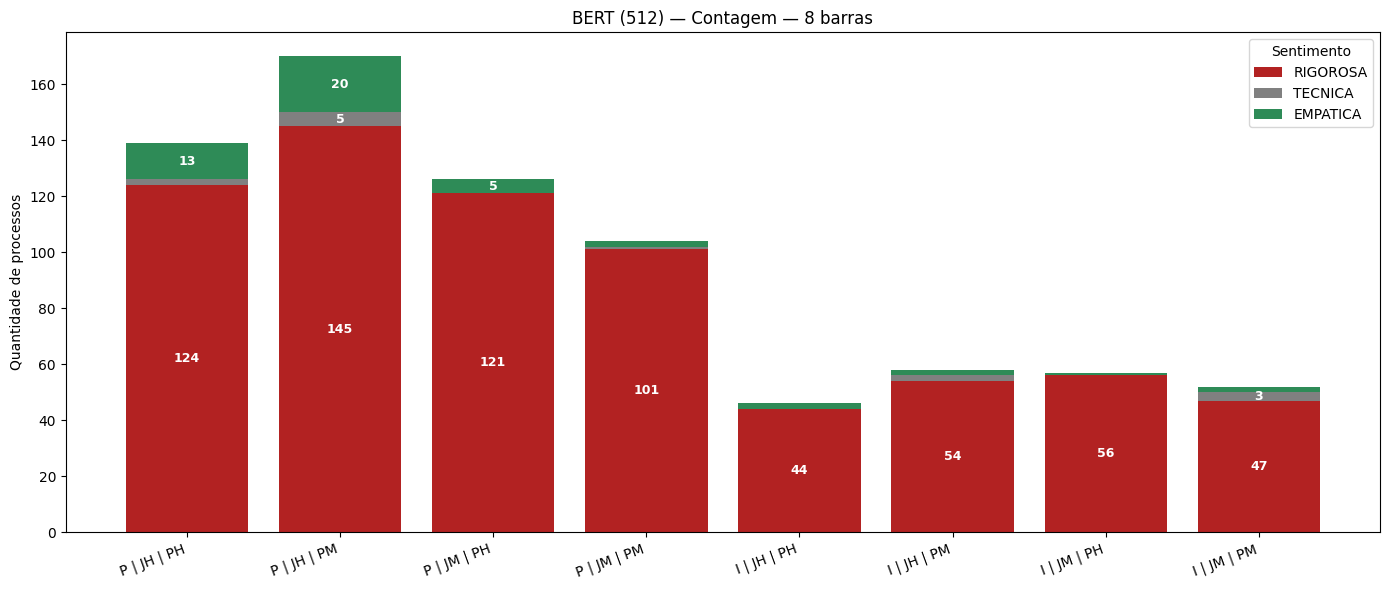

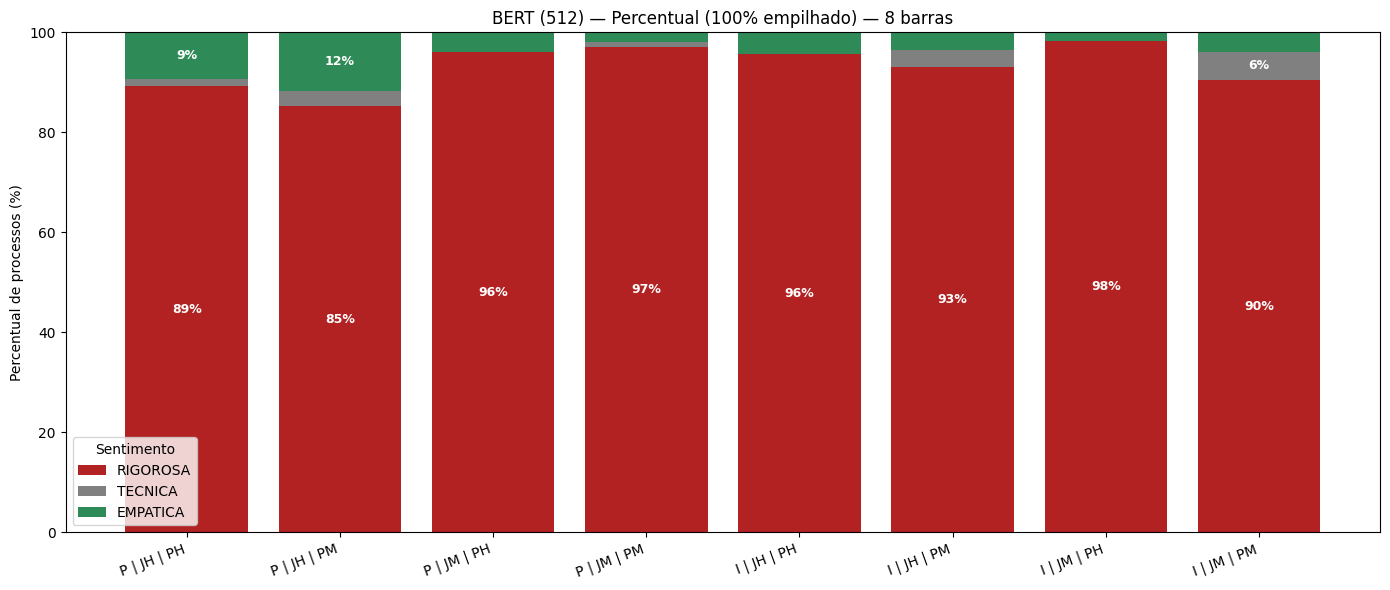

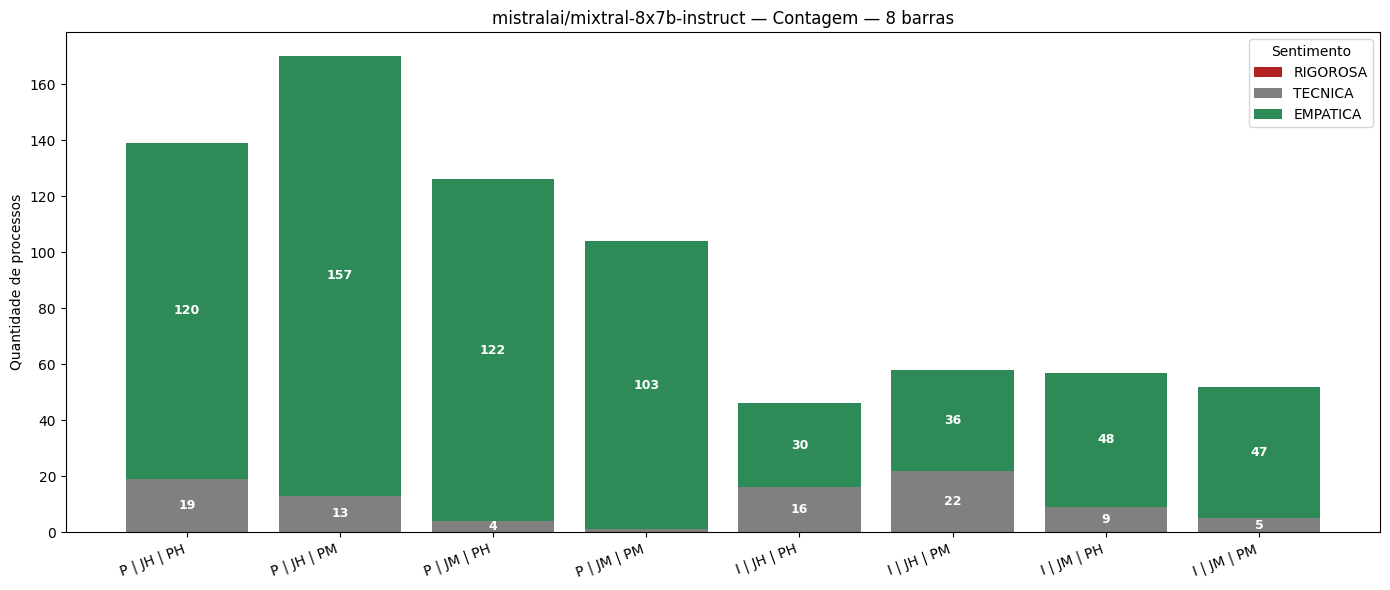

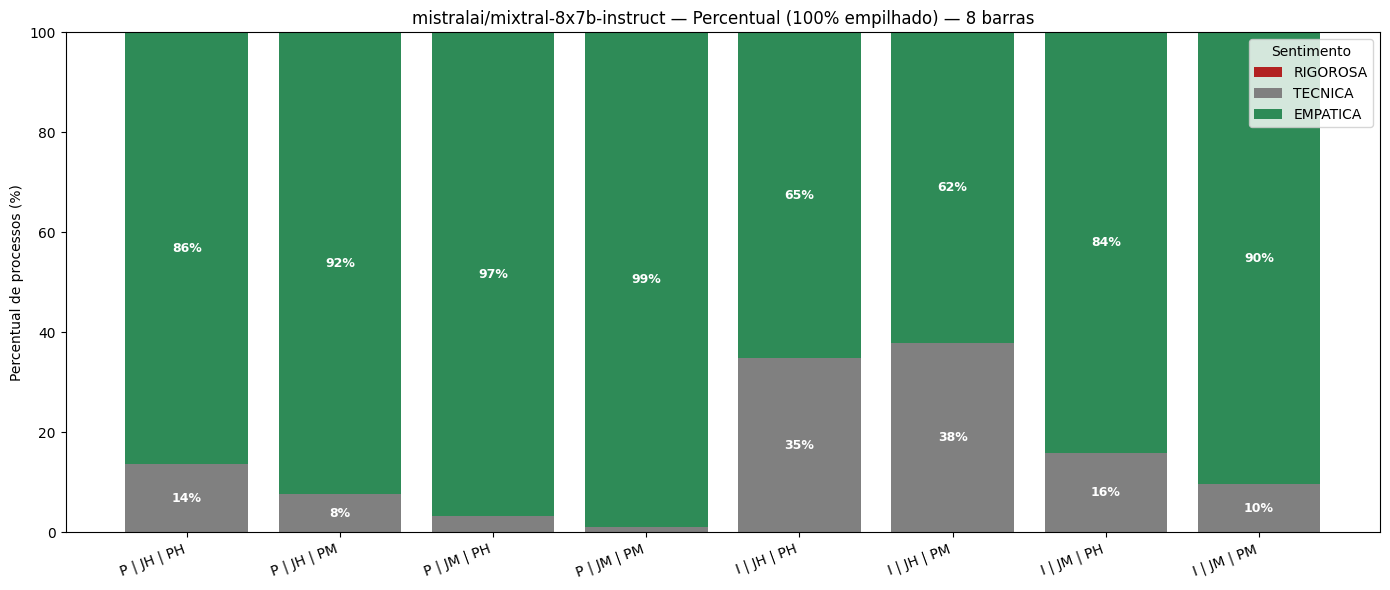

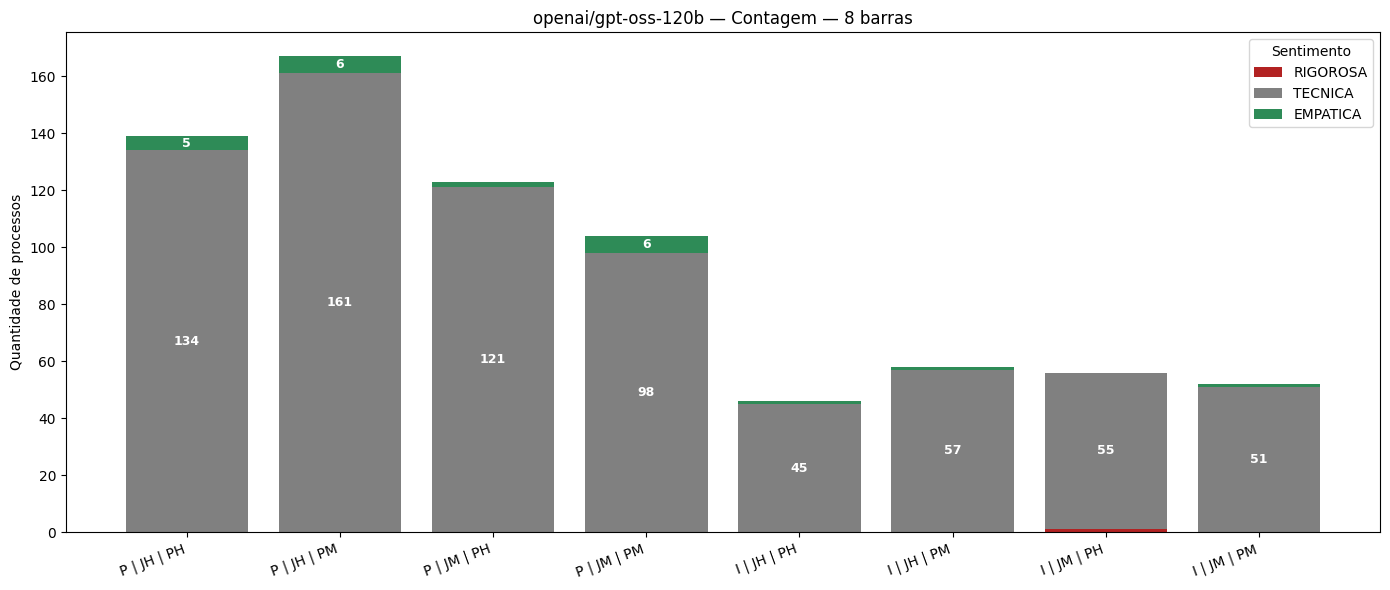

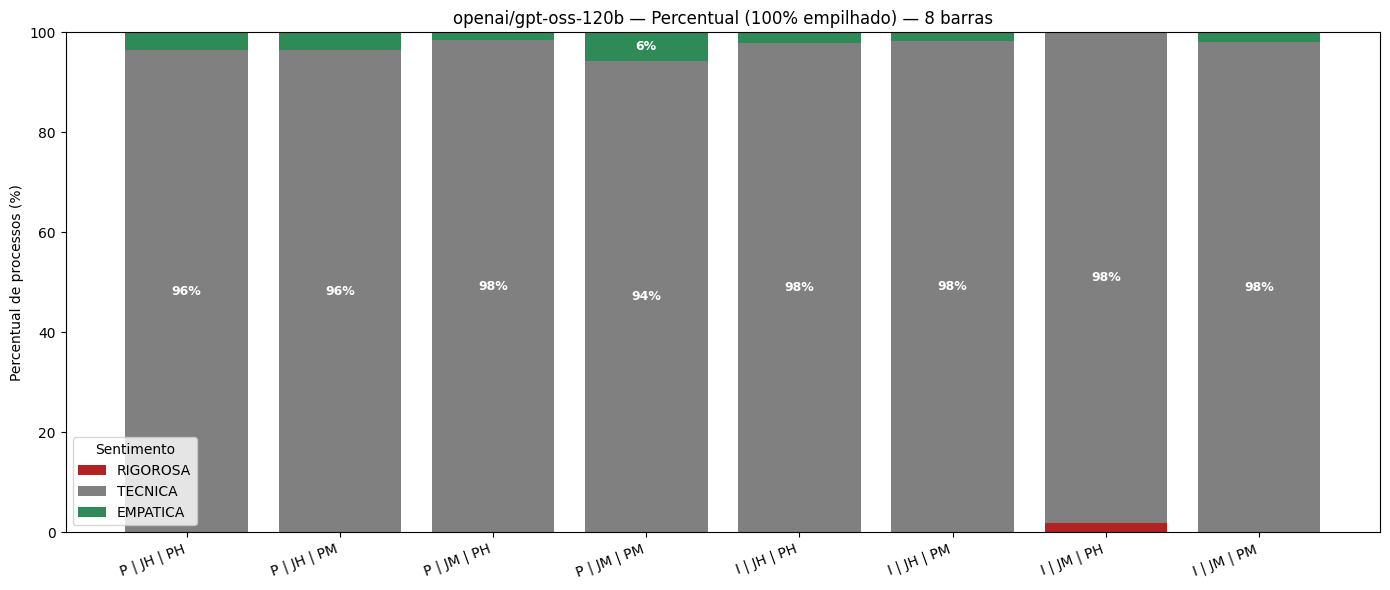

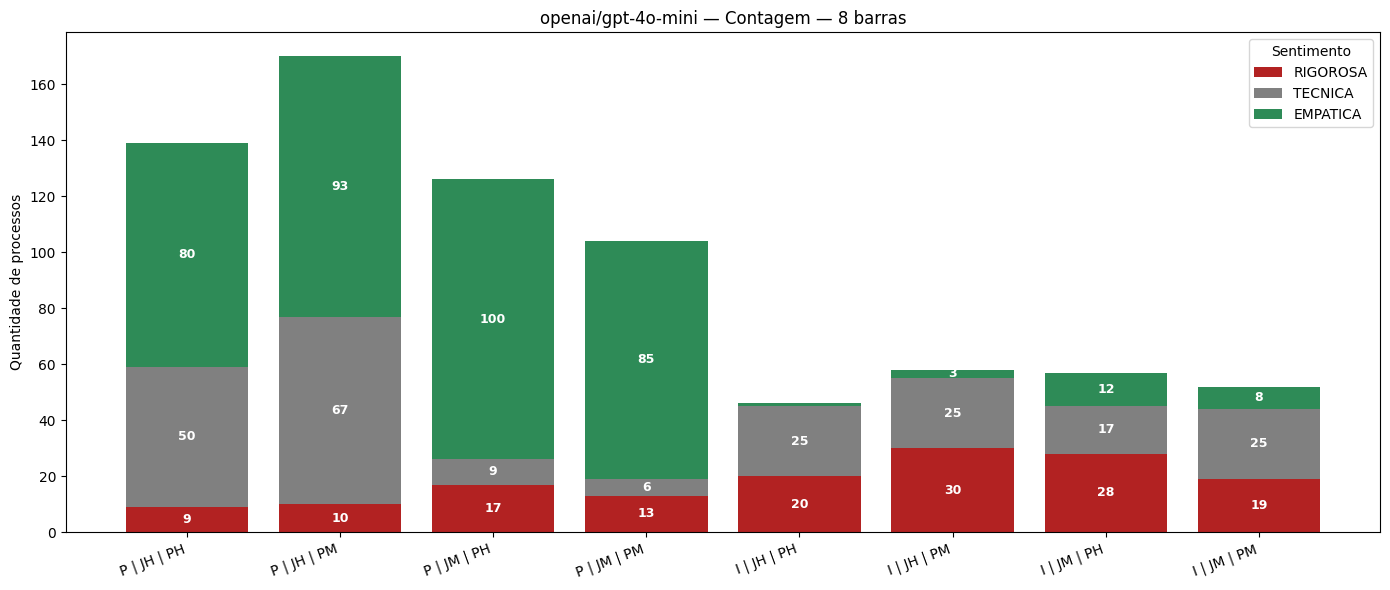

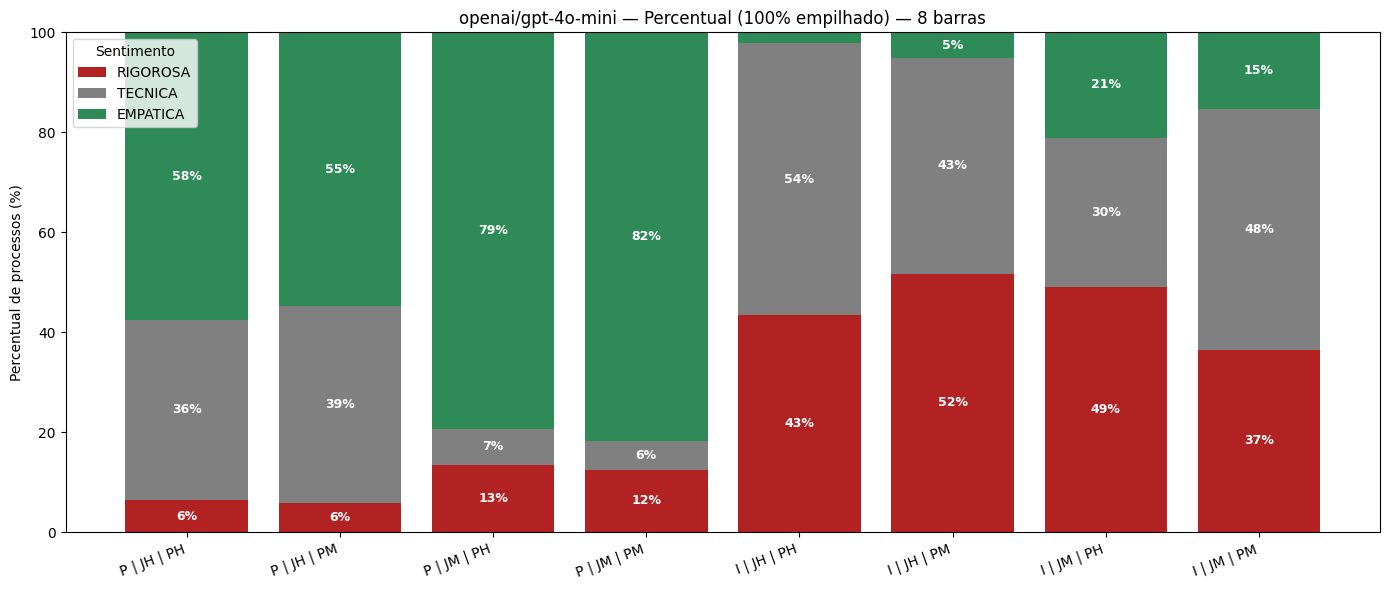

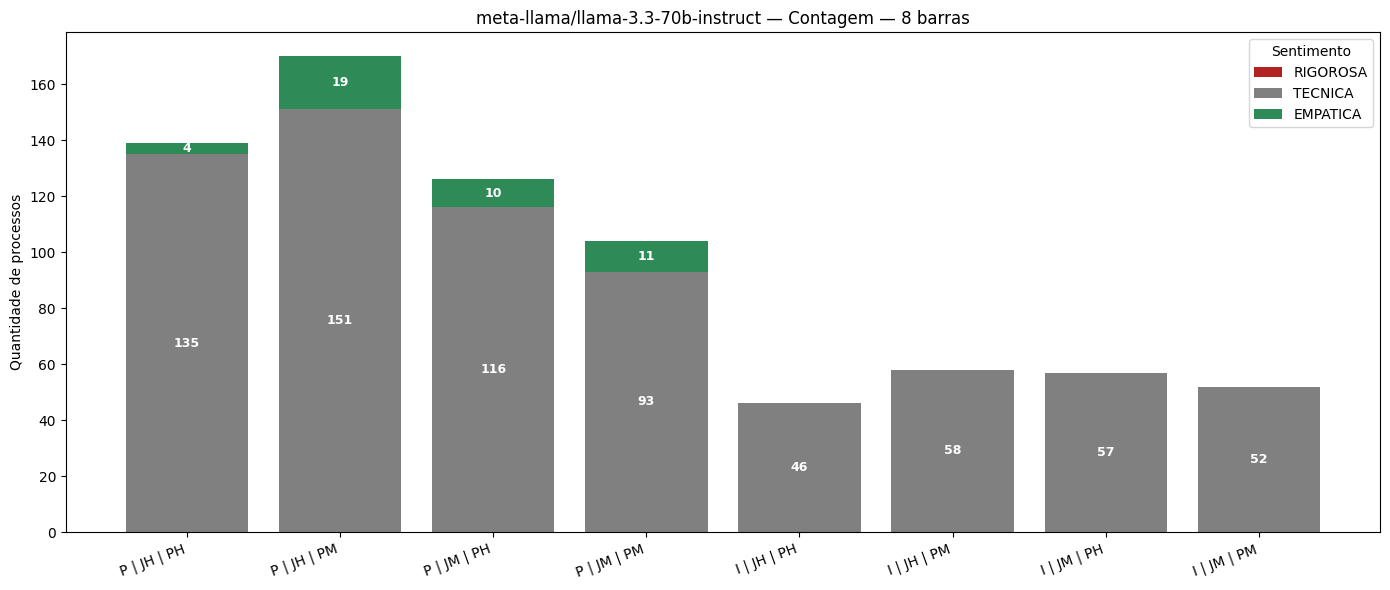

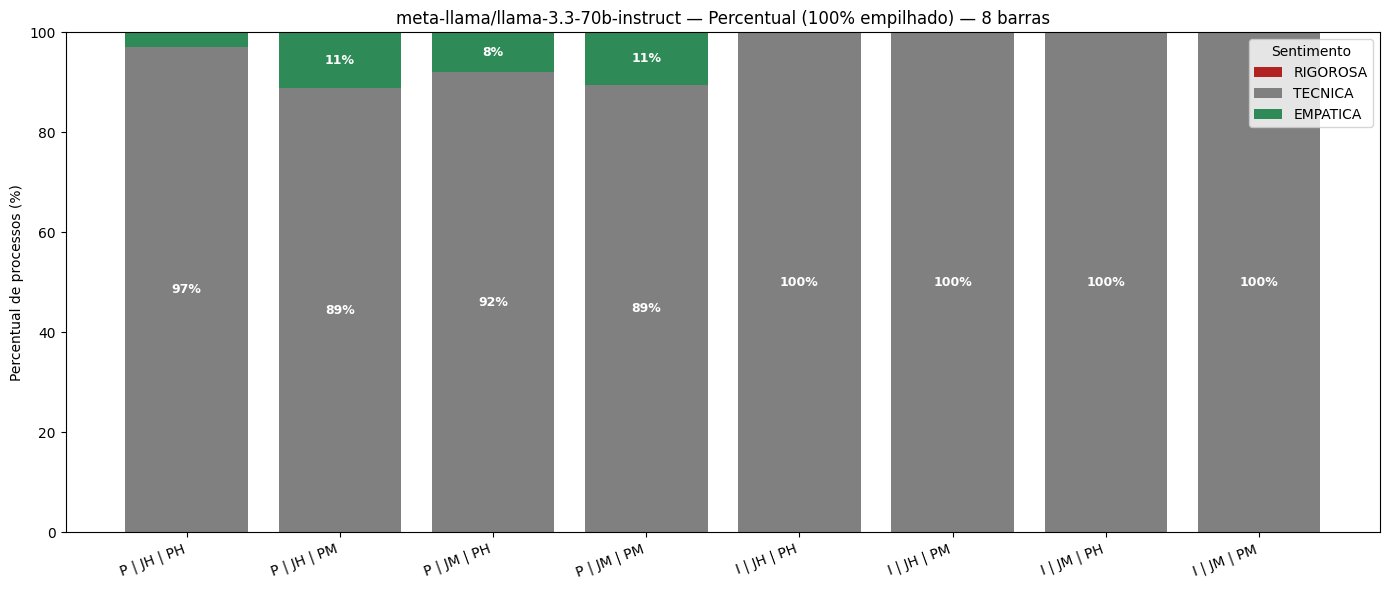

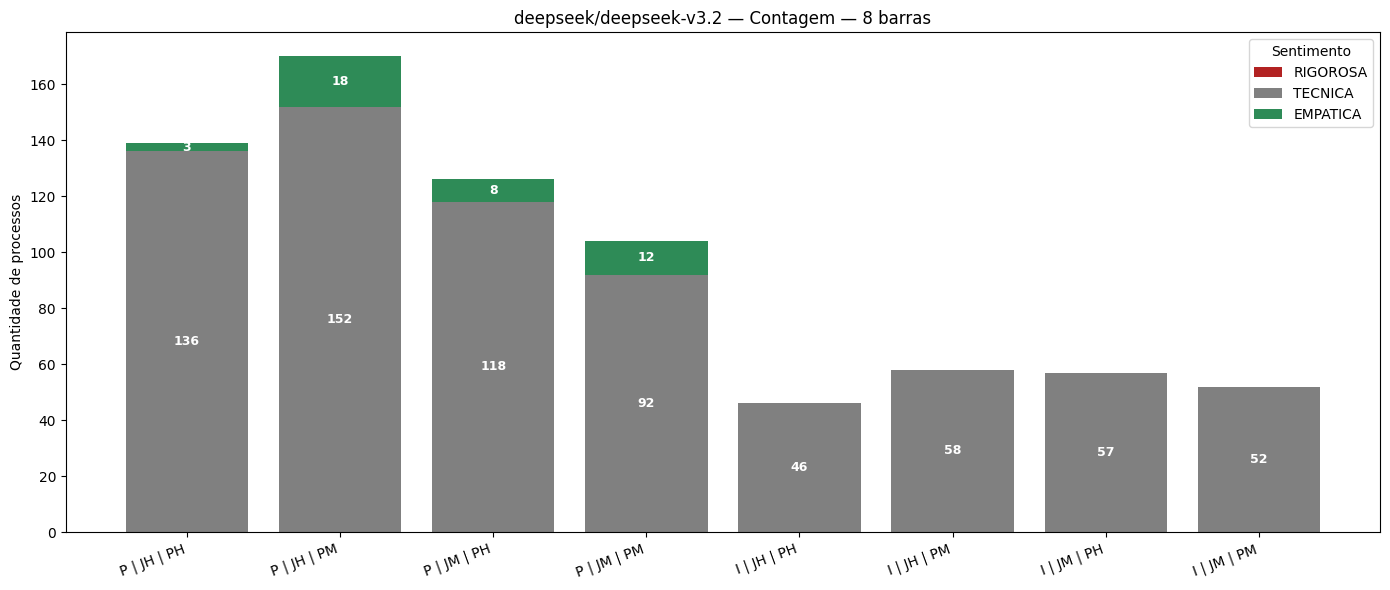

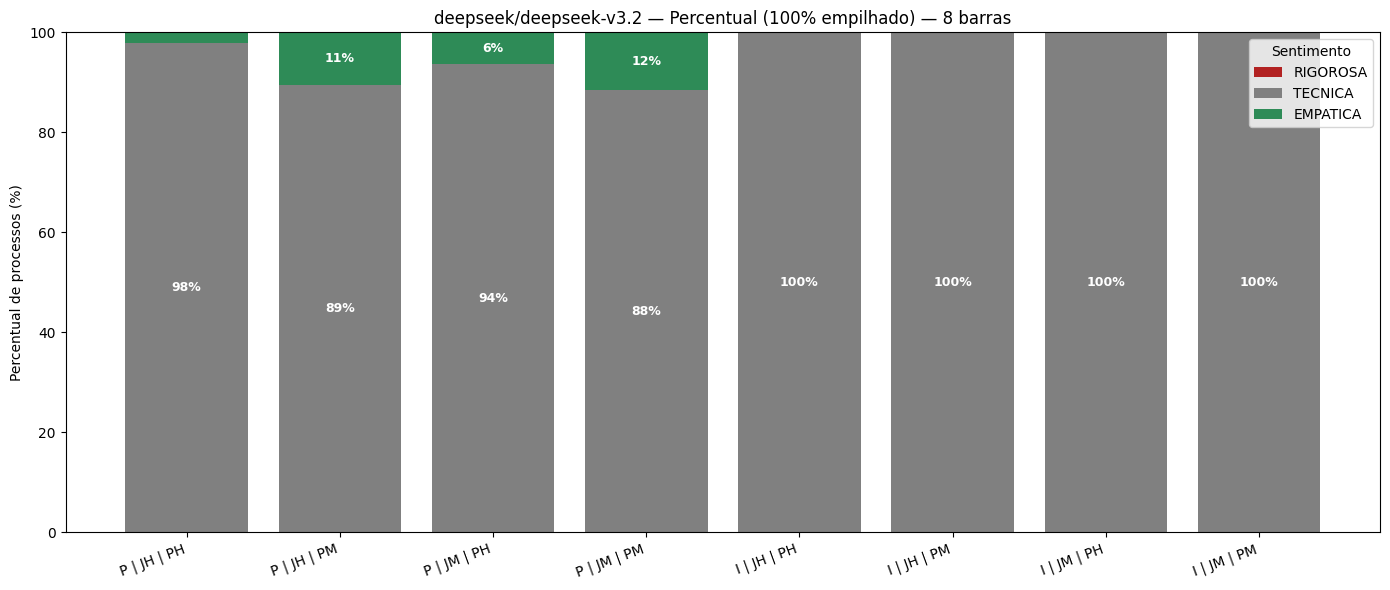

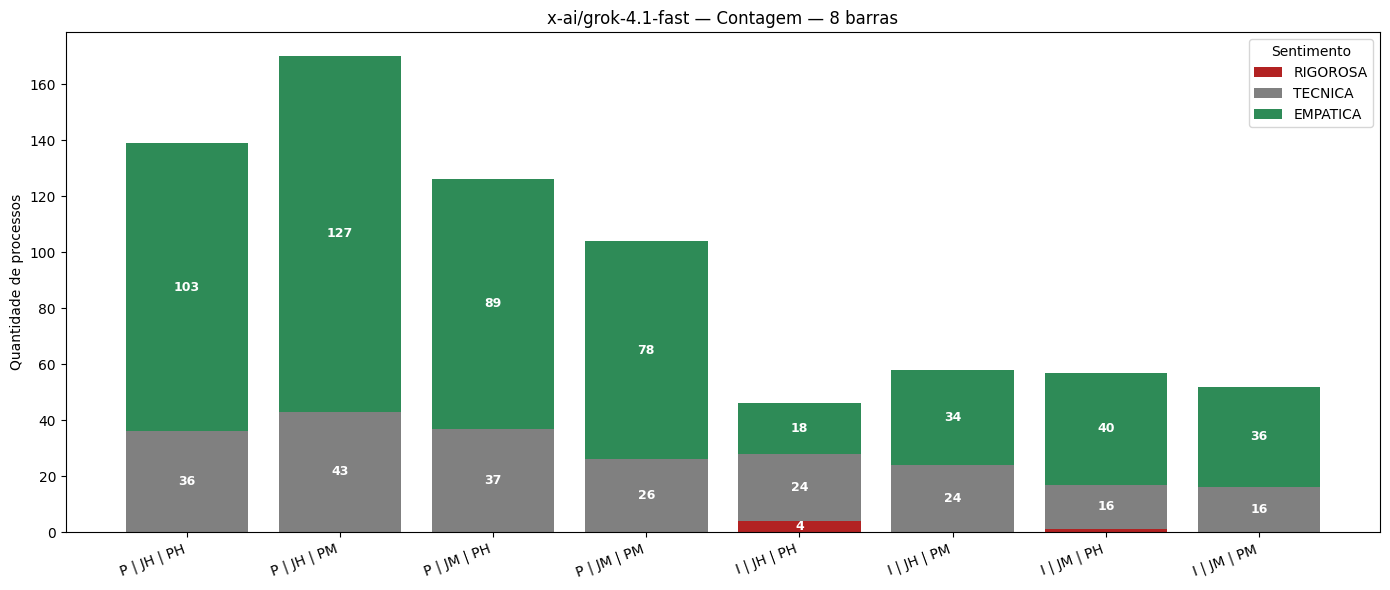

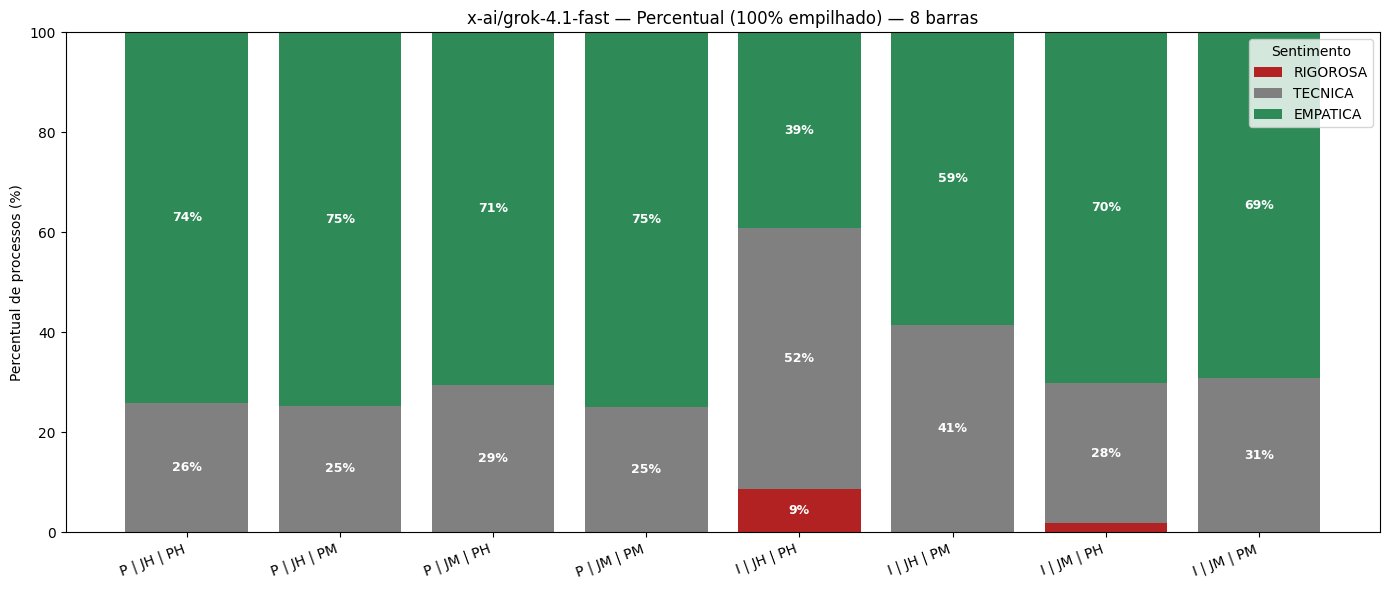

In [134]:
for nome_modelo, col in {
    "BERT (512)": "analise_bert",
    "mistralai/mixtral-8x7b-instruct": "sentimento_llm_mistral",
    "openai/gpt-oss-120b": "sentimento_llm-gpt",
    "openai/gpt-4o-mini": "sentimento_llm-gpt-mini",
    "meta-llama/llama-3.3-70b-instruct": "sentimento_llm-llama",
    "deepseek/deepseek-v3.2": "sentimento_llm-deep-seek",
    "x-ai/grok-4.1-fast": "sentimento_llm-grok",
}.items():
    plot_8_barras_empilhadas(df, col_sentimento=col, nome_modelo=nome_modelo, percentual=False)
    plot_8_barras_empilhadas(df, col_sentimento=col, nome_modelo=nome_modelo, percentual=True)

### 9.9 Boxplot

In [87]:
# Grupo combinado (Juiz x Parte)
df["grupo_jp"] = (
    "Juiz " + df["genero_juiz"].astype(str).str.strip() +
    " / Parte " + df["genero_parte"].astype(str).str.strip()
)

ORDEM_GRUPOS_JP = [
    "Juiz Masculino / Parte Masculino",
    "Juiz Masculino / Parte Feminino",
    "Juiz Feminino / Parte Masculino",
    "Juiz Feminino / Parte Feminino",
]

### 9.10 Função: Boxplot com média + anotação da média

In [88]:
def boxplot_com_media(df_in, value_col, group_col, order=None, title=None, ylim=None):
    tmp = df_in.copy()
    tmp = tmp[tmp[value_col].notna()].copy()

    if order is None:
        order = list(pd.unique(tmp[group_col]))

    data = []
    labels = []
    means = []

    for g in order:
        vals = tmp.loc[tmp[group_col] == g, value_col].dropna().astype(float).values
        if len(vals) == 0:
            continue
        data.append(vals)
        labels.append(g)
        means.append(vals.mean())

    plt.figure(figsize=(10, 5))
    plt.boxplot(data, labels=labels, showmeans=True)  # showmeans marca a média no boxplot

    # Anota a média (valor numérico) em cima do marcador
    for i, m in enumerate(means, start=1):
        plt.text(i, m, f"{m:.2f}", ha="center", va="bottom")

    plt.title(title or f"{value_col} por {group_col}")
    plt.ylabel(value_col)
    plt.xticks(rotation=20, ha="right")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.tight_layout()
    plt.show()

### 9.11 DESCRIBE (com min/max) — geral e por grupo

In [89]:
def describe_completo(df_in, value_col, group_col=None, order=None):
    print(f"\n=== DESCRIBE GERAL: {value_col} ===")
    display(df_in[value_col].describe())  # inclui min e max automaticamente

    if group_col is not None:
        print(f"\n=== DESCRIBE POR GRUPO: {group_col} ===")
        desc = df_in.groupby(group_col)[value_col].describe()
        if order is not None:
            desc = desc.reindex(order)
        display(desc)

### 9.12 Rodar para o BERT numérico (1–5)


=== DESCRIBE GERAL: analise_bert_1a5 ===


,analise_bert_1a5
count,752.000000
mean,1.293883
std,0.934650
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,5.000000



=== DESCRIBE POR GRUPO: genero_juiz ===


,count,mean,std,min,25%,50%,75%,max
genero_juiz,,,,,,,,
Masculino,413.0,1.387409,1.081637,1.0,1.0,1.0,1.0,5.0
Feminino,339.0,1.179941,0.700852,1.0,1.0,1.0,1.0,5.0


/tmp/ipython-input-1207466396.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)  # showmeans marca a média no boxplot


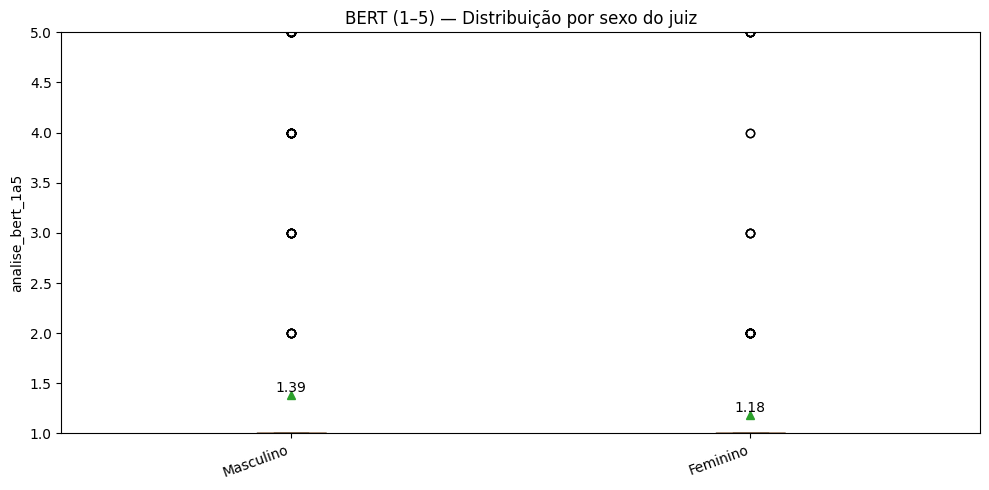

In [90]:
# @title Por sexo juiz
value_col = "analise_bert_1a5"

describe_completo(df, value_col=value_col, group_col="genero_juiz", order=["Masculino", "Feminino"])
boxplot_com_media(df, value_col=value_col, group_col="genero_juiz",
                  order=["Masculino", "Feminino"],
                  title="BERT (1–5) — Distribuição por sexo do juiz",
                  ylim=(1, 5))


In [1]:
df = pd.read_csv("")

display(df)

NameError: name 'df' is not defined

## 🔬 10. TESTES ESTATÍSTICOS

### 10.1 Importações e leitura do dataset

In [68]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import chi2_contingency

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [69]:
df = pd.read_csv("decisoes_classificadas_cs_llm_bert.csv", sep=";")
df.shape, df.columns

((752, 18),
 Index(['arquivo', 'numero_processo', 'decisao_completa', 'genero_juiz',
        'genero_parte', 'resultado_sentenca', 'decisao_processada',
        'sentimento_llm_mistral', 'sentimento_llm-gpt',
        'sentimento_llm-gpt-mini', 'sentimento_llm-llama',
        'sentimento_llm-deep-seek', 'sentimento_llm-grok',
        'trecho_decisao_4096', 'trecho_decisao_512', 'analise_bert_label',
        'analise_bert_1a5', 'analise_bert'],
       dtype='object'))

### 10.2 Preparos mínimos (sexo juiz/parte e resultado)

In [99]:
MAP_SEXO = {"Masculino": "homem", "Feminino": "mulher"}

df["juiz_sexo"]  = df["genero_juiz"].map(MAP_SEXO)
df["parte_sexo"] = df["genero_parte"].map(MAP_SEXO)

df["resultado"] = df["resultado_sentenca"].astype(str).str.strip()

# Contagem + percentual (sobre o total)
vc = df[["juiz_sexo", "parte_sexo", "resultado"]].value_counts(dropna=False)
out = (
    pd.DataFrame({
        "valor_absoluto": vc,
        "percentual": (vc / vc.sum()) * 100
    })
    .reset_index()
    .head(10)
)

out

,juiz_sexo,parte_sexo,resultado,valor_absoluto,percentual
0,homem,mulher,Procedente,170,22.606383
1,homem,homem,Procedente,139,18.484043
2,mulher,homem,Procedente,126,16.755319
3,mulher,mulher,Procedente,104,13.829787
4,homem,mulher,Improcedente,58,7.712766
5,mulher,homem,Improcedente,57,7.579787
6,mulher,mulher,Improcedente,52,6.914894
7,homem,homem,Improcedente,46,6.117021


### 10.3 Mapear sentimento (texto → número 0/1/2) para os testes 1–3
**Regras**:
* RIGOROSA=0
* TECNICA=1
* EMPATICA=2

In [74]:
MAP_SENT_NUM = {"RIGOROSA": 0, "TECNICA": 1, "EMPATICA": 2}

def sent_to_txt(x):
    """Mantém apenas RIGOROSA/TECNICA/EMPATICA; converte ERRO (e outros) para NaN."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().upper()
    if s in {"RIGOROSA", "TECNICA", "EMPATICA"}:
        return s
    return np.nan  # ex.: "ERRO"

MODELOS_SENTIMENTO = {
    "BERT (classes)": "analise_bert",
    "mistralai/mixtral-8x7b-instruct": "sentimento_llm_mistral",
    "openai/gpt-oss-120b": "sentimento_llm-gpt",
    "openai/gpt-4o-mini": "sentimento_llm-gpt-mini",
    "meta-llama/llama-3.3-70b-instruct": "sentimento_llm-llama",
    "deepseek/deepseek-v3.2": "sentimento_llm-deep-seek",
    "x-ai/grok-4.1-fast": "sentimento_llm-grok",
}

# cria colunas *_txt e *_num para cada modelo
for nome, col in MODELOS_SENTIMENTO.items():
    df[f"{col}__txt"] = df[col].apply(sent_to_txt)
    df[f"{col}__num"] = df[f"{col}__txt"].map(MAP_SENT_NUM)

# filtra registros inexistentes
df = df.dropna(subset=[f"{col}__num" for col in MODELOS_SENTIMENTO.values()])

df.filter(regex="__txt|__num")

,analise_bert__txt,analise_bert__num,sentimento_llm_mistral__txt,sentimento_llm_mistral__num,sentimento_llm-gpt__txt,sentimento_llm-gpt__num,sentimento_llm-gpt-mini__txt,sentimento_llm-gpt-mini__num,sentimento_llm-llama__txt,sentimento_llm-llama__num,sentimento_llm-deep-seek__txt,sentimento_llm-deep-seek__num,sentimento_llm-grok__txt,sentimento_llm-grok__num
0,RIGOROSA,0,EMPATICA,2,EMPATICA,2.0,EMPATICA,2,EMPATICA,2,EMPATICA,2,EMPATICA,2
2,RIGOROSA,0,EMPATICA,2,EMPATICA,2.0,EMPATICA,2,EMPATICA,2,EMPATICA,2,EMPATICA,2
3,RIGOROSA,0,EMPATICA,2,TECNICA,1.0,EMPATICA,2,TECNICA,1,TECNICA,1,EMPATICA,2
4,RIGOROSA,0,EMPATICA,2,TECNICA,1.0,EMPATICA,2,TECNICA,1,TECNICA,1,EMPATICA,2
5,RIGOROSA,0,EMPATICA,2,TECNICA,1.0,EMPATICA,2,TECNICA,1,TECNICA,1,EMPATICA,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,RIGOROSA,0,EMPATICA,2,TECNICA,1.0,EMPATICA,2,TECNICA,1,TECNICA,1,EMPATICA,2
748,RIGOROSA,0,EMPATICA,2,TECNICA,1.0,RIGOROSA,0,TECNICA,1,TECNICA,1,EMPATICA,2
749,RIGOROSA,0,EMPATICA,2,TECNICA,1.0,TECNICA,1,TECNICA,1,TECNICA,1,EMPATICA,2
750,RIGOROSA,0,TECNICA,1,TECNICA,1.0,TECNICA,1,TECNICA,1,TECNICA,1,TECNICA,1


### 10.4 Funções dos testes (sem “base”: só filtrando NaN do próprio sentimento)
**Teste 1 — t de Welch**

In [75]:
def cohens_d(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    nx, ny = len(x), len(y)
    sx, sy = x.std(ddof=1), y.std(ddof=1)
    s_pooled = np.sqrt(((nx-1)*sx**2 + (ny-1)*sy**2) / (nx + ny - 2))
    if s_pooled == 0:
        return np.nan
    return (x.mean() - y.mean()) / s_pooled

def teste_welch(df_in, col_num):
    tmp = df_in[df_in[col_num].notna()]
    x = tmp.loc[tmp["genero_juiz"] == "Masculino", col_num]
    y = tmp.loc[tmp["genero_juiz"] == "Feminino",  col_num]

    if len(x) < 2 or len(y) < 2:
        return {"status": "NA (amostra insuficiente)", "p_valor": np.nan}

    # variância zero em ambos (ou seja, grupos constantes)
    if x.nunique() == 1 and y.nunique() == 1:
        if x.iloc[0] == y.iloc[0]:
            return {"status": "NA (grupos idênticos e constantes)", "p_valor": np.nan}
        return {"status": "NA (constantes, mas diferentes)", "p_valor": 0.0}  # raro

    t_stat, p = stats.ttest_ind(x, y, equal_var=False)
    return {"status": "OK", "t_welch": t_stat, "p_valor": p}


**Teste 2 — Mann–Whitney U**

In [76]:
def teste_mannwhitney(df_in, col_num):
    tmp = df_in[df_in[col_num].notna()]
    x = tmp.loc[tmp["genero_juiz"] == "Masculino", col_num]
    y = tmp.loc[tmp["genero_juiz"] == "Feminino",  col_num]
    u_stat, p = stats.mannwhitneyu(x, y, alternative="two-sided")
    return {
        "n_masc": len(x), "n_fem": len(y),
        "mediana_masc": x.median(), "mediana_fem": y.median(),
        "u": u_stat, "p_valor": p
    }

**Teste 3 — Dois fatores (juiz e parte) com interação (OLS/ANOVA)**

In [77]:
def teste_2fatores_ols(df_in, col_num):
    tmp = df_in[df_in[col_num].notna()].copy()
    tmp["sent_num"] = tmp[col_num].astype(float)

    modelo = smf.ols("sent_num ~ C(genero_juiz) * C(genero_parte)", data=tmp).fit()
    anova = sm.stats.anova_lm(modelo, typ=2)
    return modelo, anova

**Teste 4 — Qui-quadrado (χ²) nas 3 classes (texto)**

In [78]:
def cramers_v(cont):
    chi2, p, dof, exp = chi2_contingency(cont)
    n = cont.to_numpy().sum()
    r, k = cont.shape
    denom = n * (min(r-1, k-1))
    return np.sqrt(chi2 / denom) if denom else np.nan

def teste_chi2(df_in, col_txt, por="genero_juiz"):
    tmp = df_in[df_in[col_txt].notna()]
    cont = pd.crosstab(tmp[por], tmp[col_txt])
    chi2, p, dof, exp = chi2_contingency(cont)
    return cont, {"chi2": chi2, "p_valor": p, "dof": dof, "cramers_v": cramers_v(cont)}

### 10.5 Rodar os 4 testes por modelo (GERAL + por resultado_sentenca)

In [79]:
def rodar_testes_modelo(df, col_base, nome_modelo):
    col_txt = f"{col_base}__txt"
    col_num = f"{col_base}__num"

    saida = {}
    for resultado in [None, "Procedente", "Improcedente"]:
        df_in = df if resultado is None else df[df["resultado_sentenca"] == resultado]
        label = "GERAL" if resultado is None else resultado.upper()

        out_welch = teste_welch(df_in, col_num)
        out_mw    = teste_mannwhitney(df_in, col_num)
        modelo, anova = teste_2fatores_ols(df_in, col_num)

        cont_j, out_chi_j = teste_chi2(df_in, col_txt, por="genero_juiz")
        cont_p, out_chi_p = teste_chi2(df_in, col_txt, por="genero_parte")

        saida[label] = {
            "n": int(df_in[col_num].notna().sum()),
            "welch": out_welch,
            "mannwhitney": out_mw,
            "anova_2fatores": anova,
            "chi2_por_juiz_cont": cont_j,
            "chi2_por_juiz": out_chi_j,
            "chi2_por_parte_cont": cont_p,
            "chi2_por_parte": out_chi_p,
        }

    print(f" OK: {nome_modelo}")
    return saida

In [80]:
resultados_stats = {}
for nome_modelo, col_base in MODELOS_SENT.items():
    resultados_stats[nome_modelo] = rodar_testes_modelo(df, col_base, nome_modelo)

 OK: BERT (classes)
 OK: mistralai/mixtral-8x7b-instruct
 OK: openai/gpt-oss-120b
 OK: openai/gpt-4o-mini
 OK: meta-llama/llama-3.3-70b-instruct
 OK: deepseek/deepseek-v3.2
 OK: x-ai/grok-4.1-fast


### 10.6 Tabela-resumo de p-valores

In [81]:
linhas = []
for nome_modelo, col_base in MODELOS_SENT.items():
    for recorte in ["GERAL", "PROCEDENTE", "IMPROCEDENTE"]:
        r = resultados_stats[nome_modelo][recorte]
        linhas.append({
            "modelo": nome_modelo,
            "recorte": recorte,
            "n": r["n"],
            "p_welch": r["welch"]["p_valor"],
            "p_mannwhitney": r["mannwhitney"]["p_valor"],
            "p_interacao_anova": r["anova_2fatores"].loc["C(genero_juiz):C(genero_parte)", "PR(>F)"]
                                 if "C(genero_juiz):C(genero_parte)" in r["anova_2fatores"].index else np.nan,
            "p_chi2_juiz": r["chi2_por_juiz"]["p_valor"],
            "p_chi2_parte": r["chi2_por_parte"]["p_valor"],
        })

df_resumo = pd.DataFrame(linhas)
df_resumo

,modelo,recorte,n,p_welch,p_mannwhitney,p_interacao_anova,p_chi2_juiz,p_chi2_parte
0,BERT (classes),GERAL,745,1.886508e-04,0.000417,0.550171,1.736753e-03,0.040941
1,BERT (classes),PROCEDENTE,533,6.961217e-05,0.000150,0.278807,6.873183e-04,0.324533
2,BERT (classes),IMPROCEDENTE,212,8.095901e-01,0.935362,0.439957,8.405031e-01,0.087690
3,mistralai/mixtral-8x7b-instruct,GERAL,745,5.192142e-07,0.000002,0.991047,3.167466e-06,0.364186
4,mistralai/mixtral-8x7b-instruct,PROCEDENTE,533,4.573669e-05,0.000213,0.415345,4.071772e-04,0.141549
5,mistralai/mixtral-8x7b-instruct,IMPROCEDENTE,212,6.191108e-05,0.000070,0.404583,1.288130e-04,1.000000
6,openai/gpt-oss-120b,GERAL,745,5.397127e-01,0.544539,0.113440,5.038670e-01,0.293880
7,openai/gpt-oss-120b,PROCEDENTE,533,9.653923e-01,0.966094,0.204441,1.000000e+00,0.389986
8,openai/gpt-oss-120b,IMPROCEDENTE,212,3.093960e-01,0.311499,0.273573,5.129227e-01,0.511440
9,openai/gpt-4o-mini,GERAL,745,3.848657e-02,0.003181,0.522387,1.883016e-11,0.401882


In [83]:
def diagnosticar_nan_welch(df, col_num, resultado="Improcedente"):
    tmp = df[df["resultado_sentenca"] == resultado].copy()
    tmp = tmp[tmp[col_num].notna()]

    diag = (
        tmp.groupby("genero_juiz")[col_num]
        .agg(n="count", nunique="nunique", mean="mean", std="std")
    )
    print(f"\nColuna: {col_num} | Resultado: {resultado} | N total: {len(tmp)}")
    display(diag)

# Rode para os dois casos que deram NaN:
diagnosticar_nan_welch(df, "sentimento_llm-llama__num", resultado="Improcedente")
diagnosticar_nan_welch(df, "sentimento_llm-deep-seek__num", resultado="Improcedente")


Coluna: sentimento_llm-llama__num | Resultado: Improcedente | N total: 212


,n,nunique,mean,std
genero_juiz,,,,
Feminino,108,1,1.0,0.0
Masculino,104,1,1.0,0.0



Coluna: sentimento_llm-deep-seek__num | Resultado: Improcedente | N total: 212


,n,nunique,mean,std
genero_juiz,,,,
Feminino,108,1,1.0,0.0
Masculino,104,1,1.0,0.0


### 10.7 Box

# TENTATIVA: SUMARIZAÇÃO DE TEXTO
**Descrição**: Foram realizados testes com modelos de sumarização automática com o objetivo de reduzir o tamanho dos textos decisórios antes das análises posteriores. No entanto, mesmo após tentativas prolongadas de execução (superiores a duas horas) e utilizando **GPU** com aproximadamente **21 GB de memória**, não foi possível obter resultados estáveis. Assim, a sumarização foi registrada como uma **tentativa metodológica exploratória**, mas não incorporada ao fluxo final de análise.

In [ ]:
# ler csv
import pandas as pd
df = pd.read_csv("decisoes_classificadas_cs_llm.csv", sep=";")

In [ ]:
# @title Sumarizador
from transformers import pipeline
sumarizador = pipeline("summarization", model="csebuetnlp/mT5_multilingual_XLSum")


KeyboardInterrupt: 

#### N.2. Função de resumo do summarizer

In [ ]:
# @title Função de resumo do summarizer

import torch

def resumir_texto(
    texto: str,
    max_input_tokens: int,
    min_new_tokens: int = 120,
    max_new_tokens: int = 220,
    num_beams: int = 4,
):
    tok = sumarizador.tokenizer
    model = sumarizador.model

    inputs = tok(
        texto,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_tokens,
    )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            num_beams=num_beams,
            do_sample=False,
            min_new_tokens=min_new_tokens,
            max_new_tokens=max_new_tokens,
            early_stopping=True,
        )

    return tok.decode(output_ids[0], skip_special_tokens=True).strip()

In [ ]:
# @title Tentativa de resumo para BERT (falhou)
df["resumo_bert_512"] = df["decisao_processada"].apply(
    lambda x: resumir_texto(x, max_input_tokens=512)
)


In [ ]:
# @title Tentativa de resumo para roBERTa (falhou)
df["resumo_roberta_4096"] = df["decisao_processada"].apply(
    lambda x: resumir_texto(x, max_input_tokens=4096)
)
